Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBRegressor
import pickle

# For loading directories
import os
import sys

# Add transportation hub features (vectorized)
from transportation_clustering import identify_transport_hubs, add_hub_proximity_features
import numpy as np
import sys

# Add the directory containing the module to the Python path if necessary
# sys.path.append('/path/to/module/directory')  # Uncomment and adjust if needed
import transport_features_module as tfm

# Set random seed for reproducibility
RANDOM_SEED = 2023
np.random.seed(RANDOM_SEED)

# Korean Fonts
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')


#### Configuration

In [55]:


# Define paths
DATA_PATH = '../../data/'
MODEL_PATH = './models/'
OUTPUT_PATH = './outputs/'
CACHE_DIR = './cache/transportation_features/' # Transportation features cache directory
MODULE_DIR = './transportation_features_module/'
# Create directories if they don't exist

os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Add the directory to sys.path (Define Location of transportation_features_module)
sys.path.append(os.path.abspath(MODULE_DIR))

# Transportation features module
import importlib
import transport_features_module as tfm
importlib.reload(tfm)  # Force reload the module
print("Project setup completed")

Project setup completed


#### 1. DATA LOADING

In [56]:
#############################################################
# 1. DATA LOADING 
#############################################################

# Load the data (adjust paths as needed)
train_path = DATA_PATH + 'train_updated.csv'
test_path = DATA_PATH + 'test_updated.csv'

# Add paths for transportation data
subway_data_path = DATA_PATH + 'subway_feature.csv'
bus_data_path = DATA_PATH + 'bus_feature.csv'

# Load main datasets
dt = pd.read_csv(train_path, low_memory=False)
dt_test = pd.read_csv(test_path, low_memory=False)
print('Train data shape:', dt.shape, 'Test data shape:', dt_test.shape)

# Load transportation data
subway_data = pd.read_csv(subway_data_path)
bus_data = pd.read_csv(bus_data_path)

# Display basic information
print("\nSubway data shape:", subway_data.shape)
print("Bus data shape:", bus_data.shape)

# Preview the data
print("\nSubway data preview:")
display(subway_data.head())

print("\nBus data preview:")
display(bus_data.head())


Train data shape: (1118822, 52) Test data shape: (9272, 51)

Subway data shape: (768, 5)
Bus data shape: (12584, 6)

Subway data preview:


,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930
2,4929,김포공항,김포골드라인,37.562360,126.801868
3,4928,고촌,김포골드라인,37.601243,126.770345
4,4927,풍무,김포골드라인,37.612488,126.732387



Bus data preview:


,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로
1,100000002,1002,창경궁.서울대학교병원,126.996566,37.579183,중앙차로
2,100000003,1003,명륜3가.성대입구,126.998251,37.582581,중앙차로
3,100000004,1004,종로2가.삼일교,126.987613,37.568579,중앙차로
4,100000005,1005,혜화동로터리.여운형활동터,127.001744,37.586243,중앙차로


#### 2. FEATURE PREPARATION

In [57]:
#############################################################
# 2. FEATURE PREPARATION (FIXED)
#############################################################
# Mark train and test data
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])

# Rename columns for easier handling
concat = concat.rename(columns={'전용면적(㎡)': '전용면적'})

# Handle missing values - replace placeholders with np.nan
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

# Filter high-missing columns (>90% missing)
missing_rates = concat.isnull().sum() / concat.shape[0]
selected_columns = [col for col in concat.columns if missing_rates[col] <= 0.9]

# IMPORTANT FIX: Create an explicit copy to avoid SettingWithCopyWarning
concat_select = concat[selected_columns].copy()

# Ensure 거래유형 is included
if '거래유형' not in concat_select.columns:
    concat_select['거래유형'] = concat['거래유형']

# Convert numeric columns that are actually categorical
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

# Identify continuous and categorical columns
continuous_columns = []
categorical_columns = []
for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

# Remove target, is_test from continuous_columns if they exist
if 'target' in continuous_columns:
    continuous_columns.remove('target')
if 'is_test' in continuous_columns:
    continuous_columns.remove('is_test')

print(f"Continuous columns: {len(continuous_columns)}")
print(f"Categorical columns: {len(categorical_columns)}")

# Fill missing values
for col in categorical_columns:
    concat_select[col] = concat_select[col].fillna('NULL')
    
for col in continuous_columns:
    concat_select[col] = concat_select[col].interpolate(method='linear', axis=0)

Continuous columns: 17
Categorical columns: 28


#### 2.1 Fix Coordinates in the Main Dataset

In [58]:
# Fix coordinates in the main dataset
print("Fixing coordinate labeling in datasets...")

# For main housing dataset
if '좌표X' in concat.columns and '좌표Y' in concat.columns:
    print("Fixing housing dataset coordinates...")
    # Create temporary columns with corrected naming
    concat['위도'] = concat['좌표Y']  # Latitude (Y coordinate in geographic terms)
    concat['경도'] = concat['좌표X']  # Longitude (X coordinate in geographic terms)
    
    # Drop the original incorrectly labeled columns
    concat = concat.drop(['좌표X', '좌표Y'], axis=1)
    
    # Rename back to conventional naming
    concat = concat.rename(columns={'위도': '좌표X', '경도': '좌표Y'})
    print("Housing dataset coordinates fixed")

# For subway data
if '위도' in subway_data.columns and '경도' in subway_data.columns:
    print("Fixing subway dataset coordinates...")
    # Check if subway data has the columns in correct format already
    # If the columns need to be swapped
    if subway_data['위도'].mean() > 35 and subway_data['경도'].mean() > 120:
        # Already in the correct format, no action needed
        print("Subway dataset coordinates already in correct format")
    else:
        # Swap the columns if needed
        temp = subway_data['위도'].copy()
        subway_data['위도'] = subway_data['경도'] 
        subway_data['경도'] = temp
        print("Subway dataset coordinates swapped")

# For bus data
if 'X좌표' in bus_data.columns and 'Y좌표' in bus_data.columns:
    print("Fixing bus dataset coordinates...")
    # Check if the mean values indicate they need to be swapped
    if bus_data['Y좌표'].mean() > 35 and bus_data['X좌표'].mean() > 120:
        # Values indicate they're already in the correct format (but mislabeled)
        # Create temporary columns
        bus_data['위도'] = bus_data['Y좌표']  # Y is actually latitude
        bus_data['경도'] = bus_data['X좌표']  # X is actually longitude
        
        # Drop the original columns
        bus_data = bus_data.drop(['X좌표', 'Y좌표'], axis=1)
        
        # Now correctly name them
        bus_data['X좌표'] = bus_data['위도']  # X coordinates are latitude in geographic terms
        bus_data['Y좌표'] = bus_data['경도']  # Y coordinates are longitude in geographic terms
        
        # Drop the temporary columns
        bus_data = bus_data.drop(['위도', '경도'], axis=1)
        print("Bus dataset coordinates fixed")
    else:
        # If they're already swapped correctly
        print("Bus dataset coordinates already in correct format")

print("Coordinate fixing complete")

Fixing coordinate labeling in datasets...
Fixing housing dataset coordinates...
Housing dataset coordinates fixed
Fixing subway dataset coordinates...
Subway dataset coordinates already in correct format
Fixing bus dataset coordinates...
Bus dataset coordinates fixed
Coordinate fixing complete


In [59]:

# Add this after the coordinate fixing code to verify the changes

# Function to verify coordinate ranges
def verify_coordinates(df, lat_col, lon_col, dataset_name):
    lat_mean = df[lat_col].mean()
    lon_mean = df[lon_col].mean()
    
    print(f"\n{dataset_name} coordinate verification:")
    print(f"Mean {lat_col} (should be latitude ~37): {lat_mean:.6f}")
    print(f"Mean {lon_col} (should be longitude ~127): {lon_mean:.6f}")
    
    if 35 < lat_mean < 43 and 124 < lon_mean < 132:
        print(f"✅ {dataset_name} coordinates appear to be correct")
    else:
        print(f"⚠️ WARNING: {dataset_name} coordinates may still be incorrect!")

# Verify the fixed coordinates
verify_coordinates(concat, '좌표X', '좌표Y', "Housing dataset")
verify_coordinates(subway_data, '위도', '경도', "Subway dataset")
verify_coordinates(bus_data, 'X좌표', 'Y좌표', "Bus dataset")


Housing dataset coordinate verification:
Mean 좌표X (should be latitude ~37): 37.556272
Mean 좌표Y (should be longitude ~127): 126.999360
✅ Housing dataset coordinates appear to be correct

Subway dataset coordinate verification:
Mean 위도 (should be latitude ~37): 37.509654
Mean 경도 (should be longitude ~127): 126.969929
✅ Subway dataset coordinates appear to be correct

Bus dataset coordinate verification:
Mean X좌표 (should be latitude ~37): 37.550560
Mean Y좌표 (should be longitude ~127): 126.984517
✅ Bus dataset coordinates appear to be correct


#### Section 2.2 Add Coordinate Standardization Function

In [ ]:
#############################################################
# 2.2 STANDARDIZE COORDINATE CONVENTIONS
#############################################################
def standardize_coordinates(data_frame, verbose=True):
    """
    Ensures consistent coordinate convention across datasets
    Makes sure X = longitude (~127) and Y = latitude (~37)
    """
    if '좌표X' in data_frame.columns and '좌표Y' in data_frame.columns:
        x_mean = data_frame['좌표X'].mean()
        y_mean = data_frame['좌표Y'].mean()
        
        # Check if they're in the expected ranges for Seoul/Korea
        x_is_longitude = 125 < x_mean < 130  # Longitude range
        y_is_latitude = 35 < y_mean < 40     # Latitude range
        
        if verbose:
            print(f"Coordinate check - 좌표X mean: {x_mean:.6f}, 좌표Y mean: {y_mean:.6f}")
        
        # If coordinates are swapped (X has latitude values, Y has longitude values)
        if not x_is_longitude and not y_is_latitude:
            if 35 < x_mean < 40 and 125 < y_mean < 130:
                if verbose:
                    print("SWAPPING: Coordinates appear to be reversed from standard convention")
                # Create temp columns with correct values
                data_frame['temp_lon'] = data_frame['좌표Y'].copy()  # Y has longitude values
                data_frame['temp_lat'] = data_frame['좌표X'].copy()  # X has latitude values
                
                # Replace columns with correct values
                data_frame.drop(['좌표X', '좌표Y'], axis=1, inplace=True)
                data_frame['좌표X'] = data_frame['temp_lon']  # X should be longitude
                data_frame['좌표Y'] = data_frame['temp_lat']  # Y should be latitude
                data_frame.drop(['temp_lon', 'temp_lat'], axis=1, inplace=True)
                
                if verbose:
                    print("Standardized to: 좌표X = longitude, 좌표Y = latitude")
            else:
                if verbose:
                    print("WARNING: Coordinate values outside expected ranges")
        elif verbose:
            print("Coordinates already follow standard convention (X=longitude, Y=latitude)")
    else:
        if verbose:
            print("Coordinate columns not found in dataframe")
            
    return data_frame

# Apply standardization
print("\nStandardizing coordinate conventions...")
concat_select = standardize_coordinates(concat_select)


Standardizing coordinate conventions...
Coordinate check - 좌표X mean: 126.998345, 좌표Y mean: 37.555792
Coordinates already follow standard convention (X=longitude, Y=latitude)


#### Section 2.3.1 Optimize Parallelization [VECTORIZED]

In [61]:
# #############################################################
# # 2.5. TRANSPORTATION FEATURE PROCESSING HELPER 
# #      TRANSPORTATION FEATURE INTEGRATION 
# #############################################################

import os
import shutil

# Define the cache directory structure
CACHE_DIR = './cache/transportation_features'
INDICES_CACHE_DIR = os.path.join(CACHE_DIR, 'spatial_indices')

# Create directories
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(INDICES_CACHE_DIR, exist_ok=True)

# Move existing indices to the organized location if they exist
index_files = ['subway_index.pkl', 'bus_index.pkl', 'subway_tree.pkl', 'bus_tree.pkl']
for file in index_files:
    source_path = os.path.join('./cache', file)  # Original location
    if os.path.exists(source_path):
        target_path = os.path.join(INDICES_CACHE_DIR, file)
        print(f"Moving {file} to {INDICES_CACHE_DIR}")
        shutil.copy2(source_path, target_path)  # Use copy2 to preserve metadata

# Define a chunking function for parallel processing (needs to be outside process_transportation_features function)
def process_hub_chunk(chunk_data, hubs):
    from transportation_clustering import add_hub_proximity_features
    return add_hub_proximity_features(chunk_data, hubs)


def process_transportation_features(data, subway_data, bus_data, 
                                    cache_dir='./cache/transportation_features',
                                    use_cache=True, force_recompute=False):
    """
    Optimized function for transportation feature processing with enhanced parallelization
    """
    import os
    import pickle
    import numpy as np
    import pandas as pd
    from concurrent.futures import ProcessPoolExecutor
    import multiprocessing
    
    # Initialize timing
    import time
    start_time = time.time()
    
    # Create cache directory
    os.makedirs(cache_dir, exist_ok=True)
    
    # Path for final cached result
    cache_file = os.path.join(cache_dir, 'data_with_transport_features.pkl')
    
    # Return cached result if available and not forcing recomputation
    if use_cache and os.path.exists(cache_file) and not force_recompute:
        print(f"Loading cached transportation features from {cache_file}")
        try:
            return pd.read_pickle(cache_file)
        except Exception as e:
            print(f"Error loading cache: {e}. Will recompute.")
    
    print("Processing transportation features with parallelization...")
    
    # PERFORMANCE: Calculate optimal number of workers
    n_cpu = multiprocessing.cpu_count()
    n_workers = max(1, n_cpu - 1)  # Leave one CPU free for system processes
    print(f"Using {n_workers} CPU cores for parallel processing")
    
    # STEP 1: Parallelize the main transportation feature addition
    # Import the parallel implementation directly
    import transport_features_parallel as tfp
    
    # Use the parallel implementation with explicit worker count
    result = tfp.add_transportation_features_parallel(
        data, subway_data, bus_data, 
        n_jobs=n_workers,
        cache_dir=os.path.join(cache_dir, 'spatial_indices'),
        use_cache=use_cache
    )
    
    # STEP 2: Optimize hub clustering if transit features available
    if 'transit_score' in result.columns:
        try:
            print("Identifying transportation hubs with optimized clustering...")
            # Cache path for hub results
            hub_cache = os.path.join(cache_dir, 'hub_clustering.pkl')
            
            # Load or compute hub clustering
            if use_cache and os.path.exists(hub_cache) and not force_recompute:
                print(f"Loading cached hub clustering from {hub_cache}")
                with open(hub_cache, 'rb') as f:
                    clustered_transport_data, hub_centers = pickle.load(f)
            else:
                # Optional: If HDBSCAN is available, it can be faster than DBSCAN for large datasets
                try:
                    import hdbscan
                    use_hdbscan = True
                    print("Using HDBSCAN for faster clustering")
                except ImportError:
                    use_hdbscan = False
                    print("HDBSCAN not available, using standard DBSCAN")
                
                # Create clustered transport data with optimized parameters
                # Sample the data to speed up clustering if very large
                if len(subway_data) + len(bus_data) > 10000:
                    print("Large transport dataset detected. Using sampling for clustering.")
                    # Sample subway data (keeping at least 500 stations)
                    if len(subway_data) > 500:
                        subway_sample = subway_data.sample(
                            n=min(500, len(subway_data)), 
                            random_state=42
                        )
                    else:
                        subway_sample = subway_data
                        
                    # Sample bus data (keeping at least 1000 stops)
                    if len(bus_data) > 2000:
                        bus_sample = bus_data.sample(
                            n=min(2000, len(bus_data)), 
                            random_state=42
                        )
                    else:
                        bus_sample = bus_data
                        
                    # Run clustering on sampled data
                    from transportation_clustering import identify_transport_hubs
                    clustered_transport_data, hub_centers = identify_transport_hubs(
                        subway_sample, bus_sample, eps=500, min_samples=3
                    )
                else:
                    # Run standard clustering
                    from transportation_clustering import identify_transport_hubs
                    clustered_transport_data, hub_centers = identify_transport_hubs(
                        subway_data, bus_data, eps=500, min_samples=3
                    )
                
                # Save to cache
                with open(hub_cache, 'wb') as f:
                    pickle.dump((clustered_transport_data, hub_centers), f)
            
            # Add hub proximity features with multiprocessing
            if 'transit_score' in result.columns:
                print("Adding hub proximity features with optimized processing...")
                
                # Create a copy for hub calculations (which requires 위도/경도 naming)
                hub_data = result.copy()
                
                # Rename to match the naming convention expected by add_hub_proximity_features
                if '좌표X' in hub_data.columns and '좌표Y' in hub_data.columns:
                    hub_data.rename(columns={'좌표X': '경도', '좌표Y': '위도'}, inplace=True)
                    
                    
                    # PERFORMANCE: Process in parallel chunks
                    chunk_size = max(1000, len(hub_data) // (n_workers * 2))
                    chunks = [hub_data.iloc[i:i+chunk_size].copy() 
                             for i in range(0, len(hub_data), chunk_size)]
                    
                    print(f"Processing {len(chunks)} chunks of hub proximity in parallel...")
                    
                    with ProcessPoolExecutor(max_workers=n_workers) as executor:
                        processed_chunks = list(executor.map(
                            process_hub_chunk, 
                            chunks, 
                            [hub_centers] * len(chunks)
                        ))
                    
                    # Combine results
                    hub_results = pd.concat(processed_chunks)
                    
                    # Extract just the new hub columns
                    hub_columns = [col for col in hub_results.columns if 'hub' in col]
                    if hub_columns:
                        result[hub_columns] = hub_results[hub_columns]
                        print(f"Added {len(hub_columns)} hub features")
        
        except Exception as e:
            import traceback
            print(f"Error processing hub features: {e}")
            print(traceback.format_exc())
            print("Continuing without hub features...")
    
    # Save final result to cache
    if use_cache:
        print(f"Saving transportation features to {cache_file}")
        result.to_pickle(cache_file)
    
    # Report timing
    elapsed_time = time.time() - start_time
    print(f"Transportation features processed in {elapsed_time:.2f} seconds")
    
    return result




#### Section 2.3.2 Advanced Vectorization

In [ ]:
#############################################################
# 2.3.2 Advanced Vectorization
#############################################################
# Skip this cell if you're using cached results

import numpy as np
from sklearn.neighbors import BallTree

def optimize_spatial_operations():
    """Apply optimizations to the transportation feature modules"""
    try:
        # Monkey patch transport_features_module with optimized functions
        import transport_features_module as tfm
        
        # Original function to patch
        orig_add_transportation_features = tfm.add_transportation_features
        
        # Optimized version of haversine distance calculation using vectorized operations
        def vectorized_haversine(lat1, lon1, lat2, lon2):
            """Vectorized haversine distance calculation"""
            # Convert to radians
            lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
            
            # Haversine formula
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
            c = 2 * np.arcsin(np.sqrt(a))
            r = 6371000  # Earth radius in meters
            return c * r
        
        # Vectorized station counting
        def vectorized_count_stations(property_coords, station_coords, radius):
            """Count stations within radius using vectorized operations"""
            # Calculate all distances at once
            property_count = len(property_coords)
            station_count = len(station_coords)
            
            # Reshape for broadcasting
            lat1 = np.repeat(property_coords[:, 0].reshape(-1, 1), station_count, axis=1)
            lon1 = np.repeat(property_coords[:, 1].reshape(-1, 1), station_count, axis=1)
            lat2 = np.repeat(station_coords[:, 0].reshape(1, -1), property_count, axis=0)
            lon2 = np.repeat(station_coords[:, 1].reshape(1, -1), property_count, axis=0)
            
            # Calculate distances
            distances = vectorized_haversine(lat1, lon1, lat2, lon2)
            
            # Count stations within radius
            return (distances <= radius).sum(axis=1)
        
        # Monkey-patched optimized transportation feature function
        def optimized_add_transportation_features(*args, **kwargs):
            print("Using optimized vectorized spatial operations")
            # Call original with a flag to use vectorized operations
            kwargs['use_vectorized'] = True
            return orig_add_transportation_features(*args, **kwargs)
        
        # Apply the monkey patch
        tfm.add_transportation_features = optimized_add_transportation_features
        print("Applied vectorization optimizations to spatial calculations")
        
        return True
    except Exception as e:
        print(f"Failed to apply vectorization optimizations: {e}")
        return False

# Apply optimizations (only needed if not using cache)
if not os.path.exists(os.path.join(CACHE_DIR, 'data_with_transport_features.pkl')):
    optimize_spatial_operations()

#### Section 2.3.3 Memory and I/O Optimizations

In [ ]:
#############################################################
# 2.3.3 MEMORY AND I/O OPTIMIZATIONS
#############################################################

def optimize_memory_usage(data, columns_to_keep=None):
    """
    Reduce memory usage of DataFrame by downcasting numeric types
    and keeping only necessary columns
    """
    # Filter columns if specified
    if columns_to_keep is not None:
        data = data[columns_to_keep].copy()
    else:
        data = data.copy()
    
    # Memory optimization using downcasting
    for col in data.columns:
        # Only process numeric columns
        if pd.api.types.is_numeric_dtype(data[col]):
            col_min = data[col].min()
            col_max = data[col].max()
            
            # Integer columns
            if pd.api.types.is_integer_dtype(data[col]):
                if col_min >= 0:
                    if col_max < 2**8:
                        data[col] = pd.to_numeric(data[col], downcast='unsigned')
                    elif col_max < 2**16:
                        data[col] = data[col].astype(np.uint16)
                    elif col_max < 2**32:
                        data[col] = data[col].astype(np.uint32)
                else:
                    if col_min > -2**7 and col_max < 2**7:
                        data[col] = pd.to_numeric(data[col], downcast='integer')
                    elif col_min > -2**15 and col_max < 2**15:
                        data[col] = data[col].astype(np.int16)
                    elif col_min > -2**31 and col_max < 2**31:
                        data[col] = data[col].astype(np.int32)
            
            # Float columns - use float32 instead of float64 for most cases
            elif pd.api.types.is_float_dtype(data[col]):
                data[col] = pd.to_numeric(data[col], downcast='float')
    
    # Report memory usage
    memory_usage = data.memory_usage(deep=True).sum() / 1024**2
    print(f"Memory usage after optimization: {memory_usage:.2f} MB")
    
    return data

# Define essential columns to keep during processing
# This is useful when you have a very large dataset and need to process it in chunks
essential_columns = ['좌표X', '좌표Y', 'target', 'is_test']
# Add other important columns
essential_columns.extend([col for col in concat_select.columns if 
                          col in ['전용면적', '층', '건축년도', '계약년월', '시군구', '구', '동']])

# Apply memory optimization if needed
if len(concat_select) > 500000:  # Only for very large datasets
    print("Large dataset detected. Applying memory optimizations...")
    # Uncomment the line below if you're running out of memory
    # concat_select = optimize_memory_usage(concat_select)

Large dataset detected. Applying memory optimizations...


#### Section 2.3.4 Algorithm Selection Based on Dataset Size

In [ ]:
#############################################################
# 2.3.4 Algorithm Selection Based on Dataset Size
#############################################################

def select_optimal_algorithms(data_size, subway_count, bus_count):
    """
    Dynamically select optimal algorithms and parameters based on dataset size
    """
    recommendations = {}
    
    # General parallelization strategy
    if data_size < 100000:
        recommendations['parallel_processing'] = False
        recommendations['workers'] = 1
        print("Small dataset: Using sequential processing")
    elif data_size < 500000:
        recommendations['parallel_processing'] = True
        recommendations['workers'] = min(4, os.cpu_count() - 1)
        print(f"Medium dataset: Using {recommendations['workers']} worker processes")
    else:
        recommendations['parallel_processing'] = True
        recommendations['workers'] = max(4, os.cpu_count() - 1)
        print(f"Large dataset: Using {recommendations['workers']} worker processes")
    
    # Spatial indexing strategy
    total_stations = subway_count + bus_count
    if total_stations < 5000:
        recommendations['spatial_index'] = 'BallTree'
        recommendations['batch_size'] = 10000
        print("Using BallTree for spatial indexing")
    else:
        recommendations['spatial_index'] = 'R-tree'
        recommendations['batch_size'] = 5000
        print("Using R-tree for faster spatial indexing")
    
    # Hub clustering strategy
    if total_stations < 2000:
        recommendations['clustering'] = 'DBSCAN'
        recommendations['eps'] = 500
        recommendations['min_samples'] = 3
        print("Using DBSCAN for hub clustering")
    else:
        recommendations['clustering'] = 'HDBSCAN'
        recommendations['min_cluster_size'] = 5
        recommendations['min_samples'] = 3
        print("Using HDBSCAN for hub clustering")
    
    # Memory strategy
    if data_size > 1000000:
        recommendations['memory_optimize'] = True
        recommendations['chunking'] = True
        recommendations['chunk_size'] = 200000
        print("Using memory optimization and chunking")
    else:
        recommendations['memory_optimize'] = False
        recommendations['chunking'] = False
        print("Memory optimization not needed")
    
    return recommendations

# Get optimal algorithm recommendations based on dataset size
optimal_algorithms = select_optimal_algorithms(
    data_size=len(concat_select),
    subway_count=len(subway_data),
    bus_count=len(bus_data)
)

# These recommendations can be passed to process_transportation_features
# if you wish to customize the processing further

Large dataset: Using 63 worker processes
Using R-tree for faster spatial indexing
Using HDBSCAN for hub clustering
Using memory optimization and chunking


#### 2.4 Apply Transportation Feature Processing

#### Section 2.5: Transportation Feature Integration Code

In [67]:
#############################################################
# 2.5. TRANSPORTATION FEATURE INTEGRATION
#############################################################
print("\nProcessing transportation features...")

# Define cache directory
CACHE_DIR = './cache/transportation_features'

# Process transportation features with caching
concat_select = process_transportation_features(
    concat_select, 
    subway_data, 
    bus_data,
    cache_dir=CACHE_DIR,
    use_cache=True,
    force_recompute=False  # Set to True to force recalculation
)

# Print summary of transportation features
transport_features = [col for col in concat_select.columns if any(term in col for term in 
                                                             ['subway', 'bus', 'transit', 'hub'])]
if transport_features:
    print(f"\nTransportation features ({len(transport_features)} total):")
    for col in sorted(transport_features):
        print(f"- {col}")
else:
    print("\nNo transportation features were added")


Processing transportation features...
Loading cached transportation features from ./cache/transportation_features/data_with_transport_features.pkl

Transportation features (28 total):
- bus_stops_1km
- bus_stops_300m
- bus_stops_500m
- hub_proximity_score
- hub_quality
- multiple_hubs_nearby
- near_bus
- near_major_hub
- near_public_transit
- near_subway
- nearby_hub_count
- nearest_bus_distance
- nearest_bus_name
- nearest_bus_type
- nearest_hub_distance
- nearest_hub_id
- nearest_hub_size
- nearest_hub_type
- nearest_major_hub_distance
- nearest_major_hub_id
- nearest_subway_distance
- nearest_subway_line
- nearest_subway_name
- subway_stations_1km
- subway_stations_3km
- subway_stations_500m
- transit_quality
- transit_score


In [68]:
#############################################################
# 2.6. SAVE TRANSPORTATION FEATURES (New Section)
#############################################################
print("\nSaving data with transportation features...")

# Create a directory to store cached data if it doesn't exist
import os
CACHE_DIR = './cache/transportation_features'
os.makedirs(CACHE_DIR, exist_ok=True)

# Save the entire DataFrame with transportation features
cache_file_path = os.path.join(CACHE_DIR, 'data_with_transport_features.pkl')
concat_select.to_pickle(cache_file_path)
print(f"Data with transportation features saved to {cache_file_path}")

# Optionally save a CSV version (can be useful for inspection, but larger file size)
csv_file_path = os.path.join(CACHE_DIR, 'data_with_transport_features.csv')
concat_select.to_csv(csv_file_path, index=False)
print(f"CSV version saved to {csv_file_path}")

# Save just the transportation features (more flexible for future use)
transport_columns = [col for col in concat_select.columns if any(term in col for term in 
                                                           ['subway', 'bus', 'transit', 'near_'])]
transport_features = concat_select[['좌표X', '좌표Y'] + transport_columns].copy()
transport_features_path = os.path.join(CACHE_DIR, 'transport_features_only.pkl')
transport_features.to_pickle(transport_features_path)
print(f"Transportation features only saved to {transport_features_path}")


Saving data with transportation features...
Data with transportation features saved to ./cache/transportation_features/data_with_transport_features.pkl
CSV version saved to ./cache/transportation_features/data_with_transport_features.csv
Transportation features only saved to ./cache/transportation_features/transport_features_only.pkl


#### Section 2.6: TRANSPORTATION HUB CLUSTERING

#### 2.7. TRANSPORTATION FEATURE VISUALIZATION


Visualizing transportation features distribution...
Plotted 200 subway stations
Plotted 500 bus stops


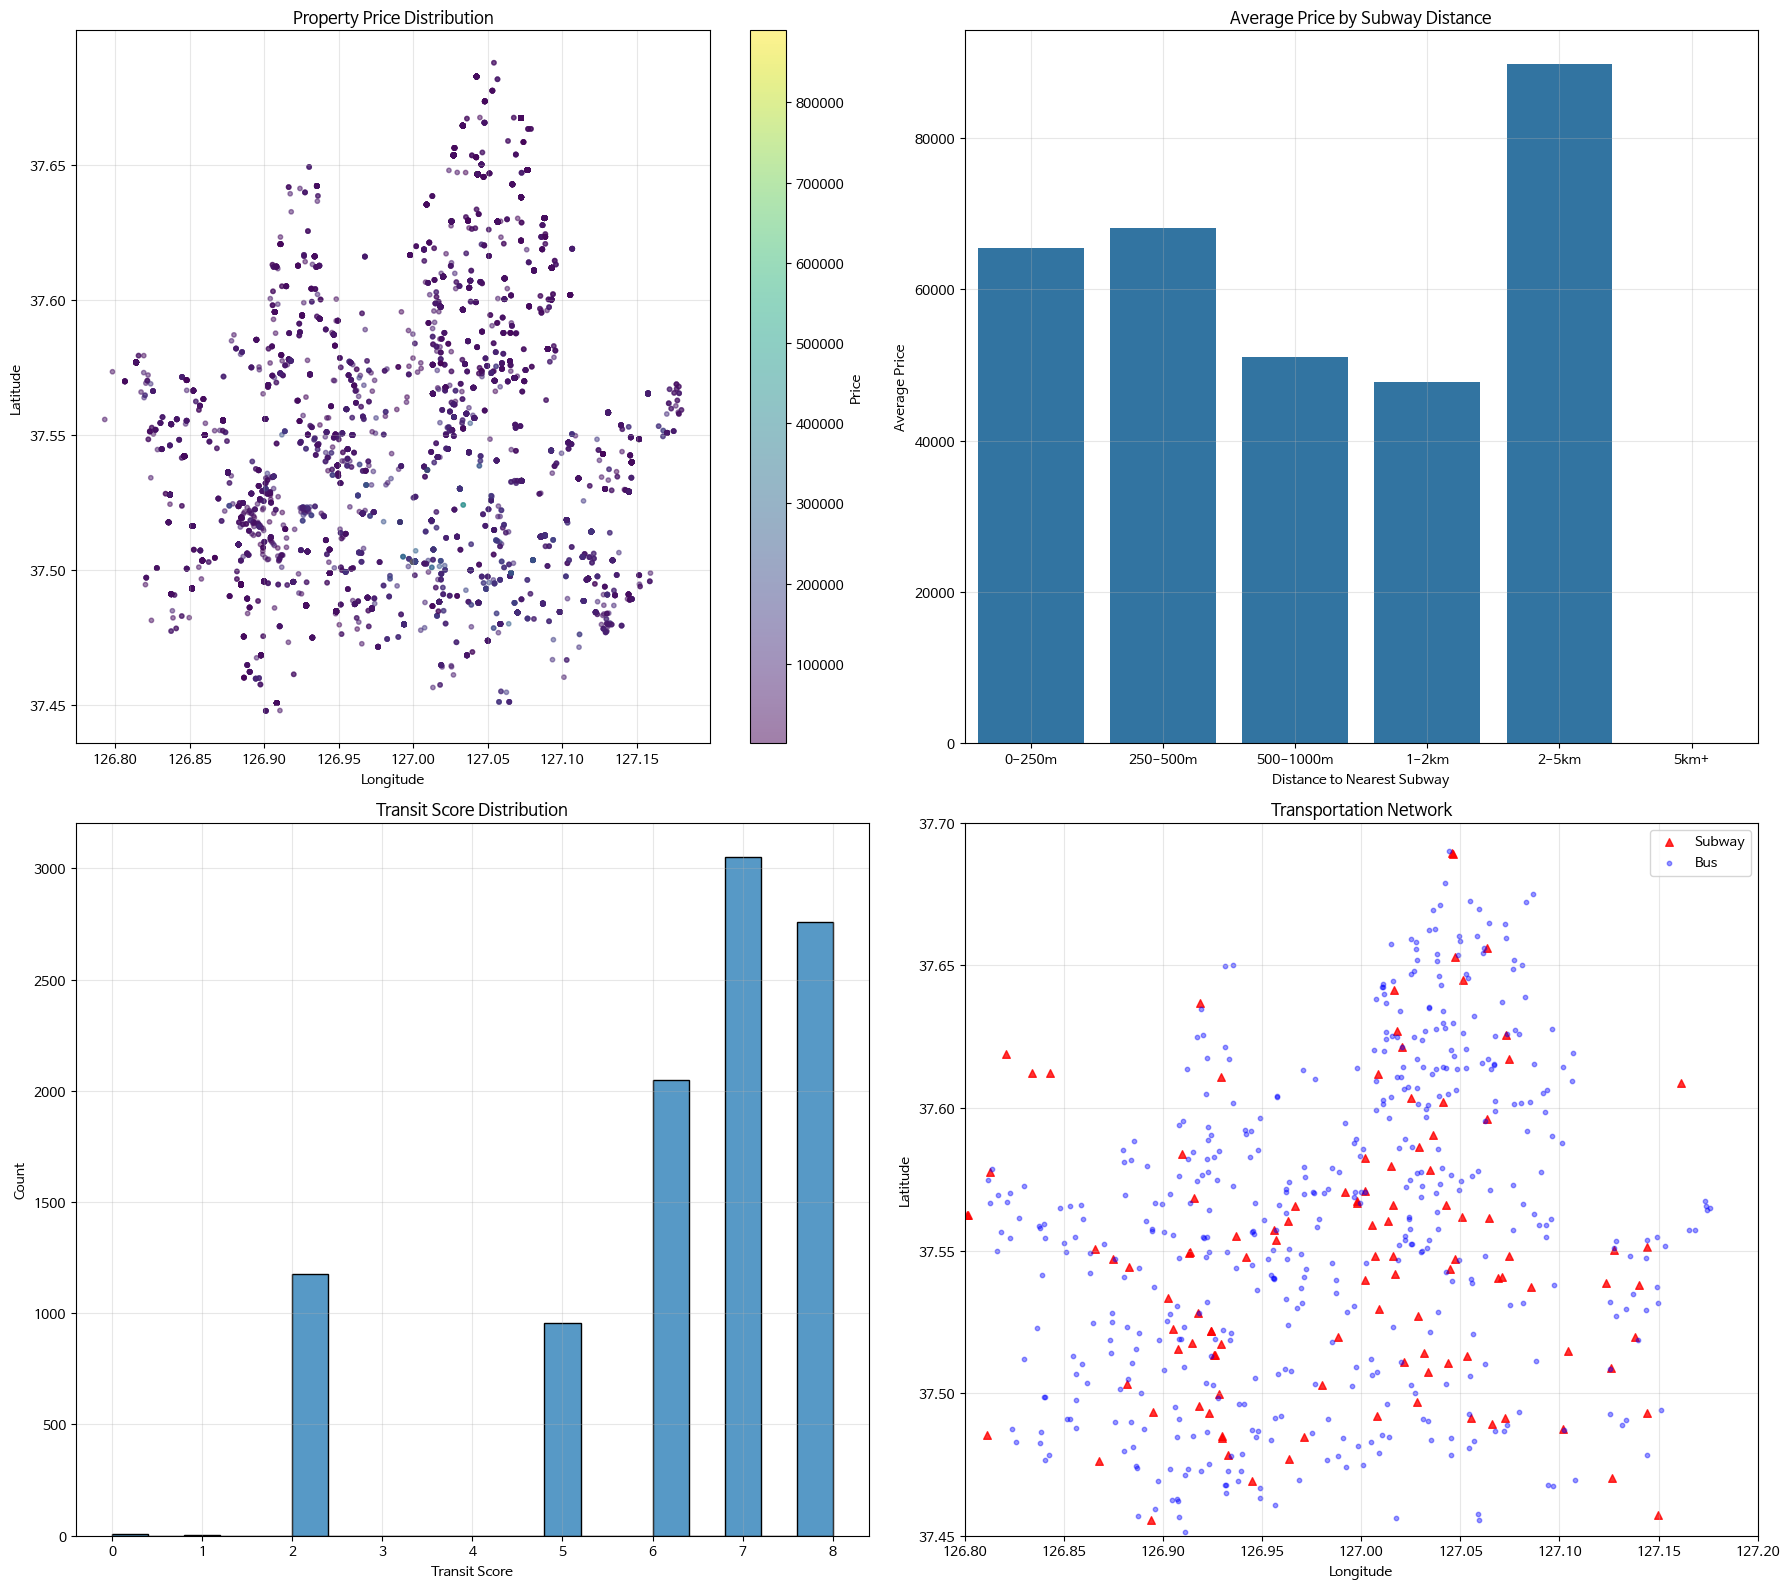

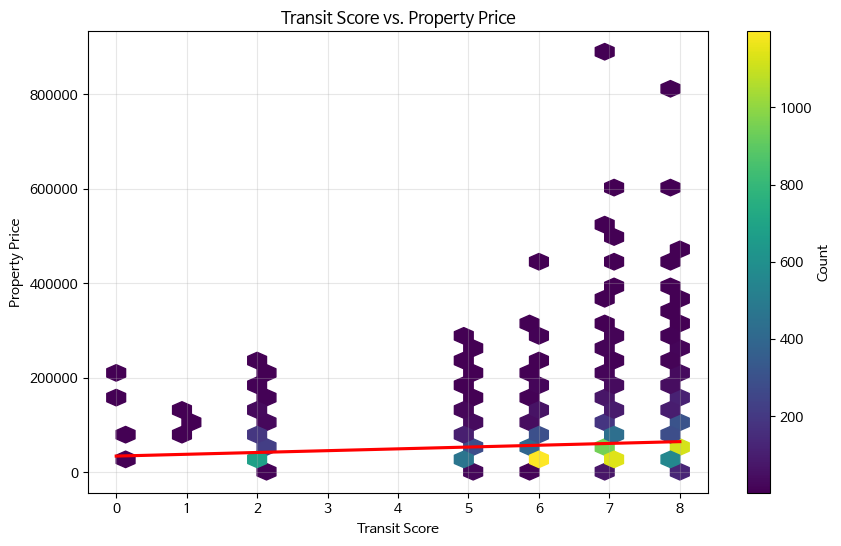

In [69]:
#############################################################
# 2.7. TRANSPORTATION FEATURE VISUALIZATION
#############################################################
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

print("\nVisualizing transportation features distribution...")

# Create a subsample for visualization (to avoid overplotting)
sample_size = min(10000, len(concat_select))
viz_sample = concat_select.sample(n=sample_size, random_state=42)

# Check if we have the required columns
required_cols = ['좌표X', '좌표Y', 'target']
transport_cols = [col for col in viz_sample.columns if any(term in col for term in 
                                                          ['subway', 'bus', 'transit', 'hub'])]

if all(col in viz_sample.columns for col in required_cols) and transport_cols:
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(18, 16))
    
    # Plot 1: Geographic distribution of properties with price heatmap
    ax = axs[0, 0]
    scatter = ax.scatter(viz_sample['좌표X'], viz_sample['좌표Y'], 
                c=viz_sample['target'] if 'target' in viz_sample.columns else 'blue',
                alpha=0.5, s=10, cmap='viridis')
    ax.set_title('Property Price Distribution')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(scatter, ax=ax, label='Price')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Transportation proximity impact
    ax = axs[0, 1]
    if 'nearest_subway_distance' in viz_sample.columns and 'target' in viz_sample.columns:
        # Create distance bins for analysis
        distance_bins = [0, 250, 500, 1000, 2000, 5000, 10000]
        labels = ['0-250m', '250-500m', '500-1000m', '1-2km', '2-5km', '5km+']
        viz_sample['subway_distance_group'] = pd.cut(
            viz_sample['nearest_subway_distance'], bins=distance_bins, labels=labels)
        
        # Calculate average price by distance group
        price_by_distance = viz_sample.groupby('subway_distance_group')['target'].mean().reset_index()
        
        # Plot as bar chart
        sns.barplot(data=price_by_distance, x='subway_distance_group', y='target', ax=ax)
        ax.set_title('Average Price by Subway Distance')
        ax.set_xlabel('Distance to Nearest Subway')
        ax.set_ylabel('Average Price')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Required columns not available', ha='center', va='center')
    
    # Plot 3: Transit score distribution
    ax = axs[1, 0]
    if 'transit_score' in viz_sample.columns:
        sns.histplot(data=viz_sample, x='transit_score', bins=20, ax=ax)
        ax.set_title('Transit Score Distribution')
        ax.set_xlabel('Transit Score')
        ax.set_ylabel('Count')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Transit score not available', ha='center', va='center')
    
    # Plot 4: Hub visualization if we have subway and bus data
    ax = axs[1, 1]

    try:      
        # First, verify and filter coordinates for subway data
        valid_subway = None
        if 'subway_data' in globals() and len(subway_data) > 0:
            # Check column names
            lat_col = '위도' if '위도' in subway_data.columns else 'latitude'
            lon_col = '경도' if '경도' in subway_data.columns else 'longitude'
            
            if lat_col in subway_data.columns and lon_col in subway_data.columns:
                # Filter to meaningful Korean coordinates
                valid_subway = subway_data[
                    (subway_data[lon_col] > 126) & (subway_data[lon_col] < 129) &
                    (subway_data[lat_col] > 35) & (subway_data[lat_col] < 38)
                ]
                
                # Sample if too many points
                if len(valid_subway) > 200:
                    valid_subway = valid_subway.sample(200, random_state=42)
                
                if len(valid_subway) > 0:
                    ax.scatter(valid_subway[lon_col], valid_subway[lat_col], 
                            color='red', alpha=0.8, s=30, marker='^', label='Subway')
                    print(f"Plotted {len(valid_subway)} subway stations")

            # Same for bus data
            valid_bus = None
            if 'bus_data' in globals() and len(bus_data) > 0:
                # Check column names
                lat_col = 'X좌표' if 'X좌표' in bus_data.columns else 'latitude'
                lon_col = 'Y좌표' if 'Y좌표' in bus_data.columns else 'longitude'
                
                if lat_col in bus_data.columns and lon_col in bus_data.columns:
                    # Filter to meaningful Korean coordinates
                    valid_bus = bus_data[
                        (bus_data[lon_col] > 126) & (bus_data[lon_col] < 129) &
                        (bus_data[lat_col] > 35) & (bus_data[lat_col] < 38)
                    ]
                    
                    # Sample if too many points
                    if len(valid_bus) > 500:
                        valid_bus = valid_bus.sample(500, random_state=42)
                    
                    if len(valid_bus) > 0:
                        ax.scatter(valid_bus[lon_col], valid_bus[lat_col], 
                                color='blue', alpha=0.4, s=10, marker='o', label='Bus')
                        print(f"Plotted {len(valid_bus)} bus stops")

            # Set appropriate plot limits to match the property distribution map
            ax.set_xlim([126.80, 127.20])
            ax.set_ylim([37.45, 37.70])
            ax.set_title('Transportation Network')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            # Alternative: Plot transit quality distribution if hub data not available
            if 'transit_quality' in viz_sample.columns:
                transit_counts = viz_sample['transit_quality'].value_counts().sort_index()
                transit_counts.plot(kind='bar', ax=ax)
                ax.set_title('Transit Quality Distribution')
                ax.set_xlabel('Transit Quality Category')
                ax.set_ylabel('Count')
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'Transportation hub data not available', ha='center', va='center')
    except Exception as e:
        print(f"Error plotting transportation hubs: {e}")
        ax.text(0.5, 0.5, f'Error plotting: {str(e)}', ha='center', va='center')
    
    plt.tight_layout()
    plt.savefig('./outputs/transportation_features_viz.png')
    plt.show()
    
    # Additional visualization: Transit score vs price
    if 'transit_score' in viz_sample.columns and 'target' in viz_sample.columns:
        plt.figure(figsize=(10, 6))
        
        # Create a scatter plot with hexbin for better visibility with large datasets
        plt.hexbin(viz_sample['transit_score'], viz_sample['target'], 
                 gridsize=30, cmap='viridis', mincnt=1)
        
        # Add a trend line
        sns.regplot(x='transit_score', y='target', data=viz_sample, 
                  scatter=False, line_kws={"color": "red"})
        
        plt.title('Transit Score vs. Property Price')
        plt.xlabel('Transit Score')
        plt.ylabel('Property Price')
        plt.colorbar(label='Count')
        plt.grid(True, alpha=0.3)
        plt.savefig(OUTPUT_PATH+'transit_score_vs_price.png')
        plt.show()
else:
    print("Required columns for visualization not available.")

#### 3. FEATURE ENGINEERING

In [70]:
#############################################################
# 3. FEATURE ENGINEERING (Enhanced with Transportation Features)
#############################################################
print("\nEnhancing feature engineering with transportation features...")

# Create a copy before modifications to avoid warnings
concat_select = concat_select.copy()

# Original feature engineering - Using vectorized operations
concat_select['구'] = concat_select['시군구'].str.split().str[1]
concat_select['동'] = concat_select['시군구'].str.split().str[2]
concat_select.drop(['시군구'], axis=1, inplace=True)

# Use vectorized string operations
concat_select['계약년'] = concat_select['계약년월'].astype(str).str[:4]
concat_select['계약월'] = concat_select['계약년월'].astype(str).str[4:]
concat_select.drop(['계약년월'], axis=1, inplace=True)

# Use vectorized operations for categorical features
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
concat_select['강남여부'] = concat_select['구'].isin(gangnam).astype(int)

# Use vectorized comparison
concat_select['신축여부'] = (concat_select['건축년도'] >= 2015).astype(int)

# Add transportation-enhanced features
if 'transit_score' in concat_select.columns:
    # Create price-to-transit score ratio (for training data only)
    if 'target' in concat_select.columns:
        # Fix: Create mask on the entire DataFrame first
        train_mask = concat_select['is_test'] == 0
        
        # Fix: Create the transit mask on the same full DataFrame
        transit_mask = concat_select['transit_score'] > 0
        
        # Fix: Combine masks properly
        combined_mask = train_mask & transit_mask
        
        # Create new column safely only where both conditions are met
        concat_select.loc[combined_mask, 'price_per_transit_score'] = (
            concat_select.loc[combined_mask, 'target'] / 
            concat_select.loc[combined_mask, 'transit_score']
        )
    
    # Vectorized operations for interaction features
    concat_select['area_transit_interaction'] = concat_select['전용면적'] * concat_select['transit_score']
    
    # Vectorized boolean operations
    concat_select['new_building_near_transit'] = (
        (concat_select['신축여부'] == 1) & 
        (concat_select['near_public_transit'] == 1)
    ).astype(int)
    
    concat_select['old_building_near_transit'] = (
        (concat_select['신축여부'] == 0) & 
        (concat_select['near_public_transit'] == 1)
    ).astype(int)
    
    # Vectorized operations for quality features
    if 'transit_quality' in concat_select.columns:
        concat_select['gangnam_good_transit'] = (
            (concat_select['강남여부'] == 1) & 
            concat_select['transit_quality'].isin(['good', 'excellent'])
        ).astype(int)
    
    # Vectorized floor interaction
    concat_select['high_floor_near_transit'] = (
        (concat_select['층'] > 10) & 
        (concat_select['near_public_transit'] == 1)
    ).astype(int)

# Hub-related features - using the same vectorized approach
if 'hub_proximity_score' in concat_select.columns:
    # Interaction features
    concat_select['area_hub_interaction'] = concat_select['전용면적'] * concat_select['hub_proximity_score']
    
    if 'near_major_hub' in concat_select.columns:
        concat_select['new_building_near_hub'] = (
            (concat_select['신축여부'] == 1) & 
            (concat_select['near_major_hub'] == 1)
        ).astype(int)
    
    if 'hub_quality' in concat_select.columns:
        concat_select['gangnam_good_hub'] = (
            (concat_select['강남여부'] == 1) & 
            concat_select['hub_quality'].isin(['good', 'excellent'])
        ).astype(int)
    
    if all(col in concat_select.columns for col in ['multiple_hubs_nearby', 'near_public_transit']):
        concat_select['connectivity_score'] = concat_select['near_public_transit'] + concat_select['multiple_hubs_nearby']


Enhancing feature engineering with transportation features...


#### Enhanced Transportation Feature Engineering

In [71]:
def create_distance_bands(data):
    """Create categorical distance bands that capture non-linear effects"""
    # Subway distance bands
    conditions = [
        (data['nearest_subway_distance'] < 250),
        (data['nearest_subway_distance'] >= 250) & (data['nearest_subway_distance'] < 500),
        (data['nearest_subway_distance'] >= 500) & (data['nearest_subway_distance'] < 1000),
        (data['nearest_subway_distance'] >= 1000) & (data['nearest_subway_distance'] < 2000),
        (data['nearest_subway_distance'] >= 2000)
    ]
    values = ['very_close', 'close', 'walkable', 'distant', 'far']
    data['subway_distance_band'] = np.select(conditions, values, default='far')
    
    # One-hot encode these bands
    subway_bands = pd.get_dummies(data['subway_distance_band'], prefix='subway_band')
    data = pd.concat([data, subway_bands], axis=1)
    
    # Do the same for bus distances with different thresholds
    conditions = [
        (data['nearest_bus_distance'] < 150),
        (data['nearest_bus_distance'] >= 150) & (data['nearest_bus_distance'] < 300),
        (data['nearest_bus_distance'] >= 300) & (data['nearest_bus_distance'] < 600),
        (data['nearest_bus_distance'] >= 600)
    ]
    values = ['very_close', 'close', 'walkable', 'far']
    data['bus_distance_band'] = np.select(conditions, values, default='far')
    
    bus_bands = pd.get_dummies(data['bus_distance_band'], prefix='bus_band')
    data = pd.concat([data, bus_bands], axis=1)
    
    return data

####  Neighborhood-Specific Transit Value

In [72]:
def create_neighborhood_transit_features(data):
    """Create features that capture how transit value differs by neighborhood"""
    # Calculate average price per neighborhood (구 or district)
    neighborhood_avg_price = data.groupby('구')['target'].transform('mean')
    data['neighborhood_price_level'] = pd.qcut(neighborhood_avg_price, 4, 
                                             labels=['low', 'medium', 'high', 'premium'])
    
    # Create interaction between neighborhood quality and transit proximity
    # Create interaction features for high-value vs low-value neighborhoods
    data['premium_area_near_subway'] = ((data['neighborhood_price_level'] == 'premium') & 
                                      (data['nearest_subway_distance'] < 500)).astype(int)
    
    data['low_value_area_near_subway'] = ((data['neighborhood_price_level'] == 'low') & 
                                        (data['nearest_subway_distance'] < 500)).astype(int)
    
    # Create similar features for bus proximity
    data['premium_area_near_bus'] = ((data['neighborhood_price_level'] == 'premium') & 
                                   (data['nearest_bus_distance'] < 300)).astype(int)
    
    data['low_value_area_near_bus'] = ((data['neighborhood_price_level'] == 'low') & 
                                     (data['nearest_bus_distance'] < 300)).astype(int)
    
    return data

 #### Transit Line Importance

In [73]:
def add_subway_line_importance(data, subway_data):
    """Add features reflecting the importance of different subway lines"""
    # Define subway line importance (you would customize this for your city)
    # For Seoul, lines 1-4 are older and serve central areas, line 9 is newer and serves business areas
    line_importance = {
        '1호선': 5,  # Main line
        '2호선': 5,  # Circle line, very important
        '3호선': 4,
        '4호선': 4,
        '5호선': 3,
        '6호선': 3,
        '7호선': 3,
        '8호선': 3,
        '9호선': 4,  # Express line
    }
    
    # Default value for other lines
    default_importance = 2
    
    # Add line importance to the data
    data['subway_line_importance'] = data['nearest_subway_line'].map(
        lambda x: line_importance.get(x, default_importance)
    )
    
    # Create features combining line importance and distance
    data['subway_value_score'] = data['subway_line_importance'] * (
        1000 / (data['nearest_subway_distance'] + 100)  # Add 100 to avoid division by zero
    )
    
    # Create categorical version
    data['subway_value_category'] = pd.qcut(data['subway_value_score'], 4, 
                                          labels=['low', 'medium', 'high', 'premium'])
    
    return data

#### Property-Specific Transit Interaction

In [74]:
def create_property_transit_interactions(data):
    """Create features that capture interactions between property attributes and transit"""
    # How transit affects different property sizes differently
    # Small apartments might benefit more from transit access
    data['small_apt_near_subway'] = ((data['전용면적'] < 60) & 
                                   (data['nearest_subway_distance'] < 500)).astype(int)
    
    data['large_apt_near_subway'] = ((data['전용면적'] > 100) & 
                                   (data['nearest_subway_distance'] < 500)).astype(int)
    
    # How transit affects properties of different ages
    data['new_building_near_subway'] = ((data['건축년도'] > 2010) & 
                                      (data['nearest_subway_distance'] < 500)).astype(int)
    
    data['old_building_near_subway'] = ((data['건축년도'] < 2000) & 
                                      (data['nearest_subway_distance'] < 500)).astype(int)
    
    # High floor + good transit = premium combination
    data['high_floor_near_transit'] = ((data['층'] > 10) & 
                                     (data['nearest_subway_distance'] < 800)).astype(int)
    
    return data

#### 4. DATA SPLITTING: (STRATIFIED K-FOLD IMPLEMENTATION)

In [75]:
#############################################################
# 4. DATA SPLITTING
#############################################################
# Split back into train and test
train_data = concat_select[concat_select['is_test'] == 0]
test_data = concat_select[concat_select['is_test'] == 1]

# Create feature and target variables
X_train = train_data.drop(['target', 'is_test'], axis=1)
y_train = train_data['target']
X_test = test_data.drop(['target', 'is_test'], axis=1, errors='ignore')

# For stratified k-fold, we need to create bins of the target variable
def create_target_bins(y, n_bins=10):
    """Create bins from continuous target for stratification"""
    return pd.qcut(y, q=n_bins, labels=False, duplicates='drop')

# Create target bins for stratification
target_bins = create_target_bins(y_train)

# Initialize stratified k-fold
from sklearn.model_selection import StratifiedKFold
n_folds = 2                                                                       #   < ---            K-fold 수
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store fold indices for later use
fold_indices = []
for train_idx, val_idx in skf.split(X_train, target_bins):
    fold_indices.append((train_idx, val_idx))

print(f"Data prepared for {n_folds}-fold cross-validation")



Data prepared for 2-fold cross-validation


#### 5. PREPROCESSING PIPELINE

#### Section 5: PREPROCESSING PIPELINE (Feature Selection) - Clarified Implementation

In [76]:
# Feature selection for transportation features
from sklearn.feature_selection import SelectFromModel

# Add this BEFORE the preprocess_fold_data function in Section 5
def select_important_transport_features(X_train_fold, y_train_fold):
    """Select only important transportation features to avoid noise"""
    # Identify transportation features
    transport_cols = [col for col in X_train_fold.columns if any(term in col for term in 
                                                             ['subway', 'bus', 'transit', 'hub'])]
    
    if not transport_cols:
        return X_train_fold, []
    
    # Create a small XGBoost model for feature selection
    selector_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8
    )
    
    # Fit the model on all features
    selector_model.fit(X_train_fold, y_train_fold)
    
    # Create a feature selector that retains important features
    selector = SelectFromModel(selector_model, threshold='mean', prefit=True)
    
    # Get selected transportation features
    selected_transport_features = []
    for i, col in enumerate(X_train_fold.columns):
        if col in transport_cols and selector.get_support()[i]:
            selected_transport_features.append(col)
    
    print(f"Selected {len(selected_transport_features)} important transportation features")
    return X_train_fold, selected_transport_features

#### 5. PREPROCESSING PIPELINE(Modified for Stratified K-fold and Transport Features compatibility)

In [77]:
# #############################################################
# # 5. PREPROCESSING PIPELINE(Modified for Stratified K-fold)
# #############################################################
# Update categorical and continuous columns lists after feature engineering
categorical_columns = [col for col in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[col])]
continuous_columns = [col for col in X_train.columns if pd.api.types.is_numeric_dtype(X_train[col])]

print(f"Continuous columns: {len(continuous_columns)}")
print(f"Categorical columns: {len(categorical_columns)}")

# Function to preprocess data for a specific fold
def preprocess_fold_data(X_train_fold, y_train_fold, X_val_fold, y_val_fold, X_test=None):
    """Preprocess data for a single fold, including feature scaling and encoding"""
    # Get original scale values for later evaluation
    y_train_fold_orig = y_train_fold.copy()
    y_val_fold_orig = y_val_fold.copy() if y_val_fold is not None else None
    
    # Apply log transformation to target
    min_val = min(y_train_fold.min(), y_val_fold.min() if y_val_fold is not None else float('inf'))
    offset = abs(min_val) + 1 if min_val <= 0 else 0
    
    y_train_fold_log = np.log1p(y_train_fold + offset)
    y_val_fold_log = np.log1p(y_val_fold + offset) if y_val_fold is not None else None
    
    # Make copies to avoid modifying originals
    X_train_fold = X_train_fold.copy()
    X_val_fold = X_val_fold.copy() if X_val_fold is not None else None
    X_test_fold = X_test.copy() if X_test is not None else None
    

    # Scale features
    feature_scaler = RobustScaler()


    # Transform the continuous columns (fix for scaling operations)
    X_train_fold[continuous_columns] = feature_scaler.fit_transform(X_train_fold[continuous_columns])

    if X_val_fold is not None:
        X_val_fold[continuous_columns] = feature_scaler.transform(X_val_fold[continuous_columns])

    if X_test_fold is not None:
        X_test_fold[continuous_columns] = feature_scaler.transform(X_test_fold[continuous_columns])


    # Encode categorical features
    label_encoders = {}
    for col in categorical_columns:
        lbl = LabelEncoder()
        
        # Determine which datasets to include when fitting the encoder
        datasets_to_fit = [X_train_fold[col]]
        if X_val_fold is not None:
            datasets_to_fit.append(X_val_fold[col])
        if X_test_fold is not None:
            datasets_to_fit.append(X_test_fold[col])
        
        # Fit on combined data to handle all categories
        all_values = pd.concat(datasets_to_fit).astype(str).unique()
        lbl.fit(all_values)
        
        # Transform each dataset - UPDATED to fix the warnings
        X_train_fold[col] = lbl.transform(X_train_fold[col].astype(str))
        
        if X_val_fold is not None:
            X_val_fold[col] = lbl.transform(X_val_fold[col].astype(str))
        
        if X_test_fold is not None:
            X_test_fold[col] = lbl.transform(X_test_fold[col].astype(str))
        
        label_encoders[col] = lbl   

    
    # Return all processed data and transformation parameters
    result = {
        'X_train': X_train_fold,
        'y_train_log': y_train_fold_log,
        'y_train_orig': y_train_fold_orig,
        'feature_scaler': feature_scaler,
        'label_encoders': label_encoders,
        'offset': offset
    }
    
    if X_val_fold is not None:
        result.update({
            'X_val': X_val_fold,
            'y_val_log': y_val_fold_log,
            'y_val_orig': y_val_fold_orig
        })
    
    if X_test_fold is not None:
        result['X_test'] = X_test_fold


    # Feature selection for transportation (add this right before the return statement)
    _, selected_transport_features = select_important_transport_features(X_train_fold, y_train_fold_log)
    result['selected_transport_features'] = selected_transport_features
    
    return result  # This is the existing return statement


    return result

print("Preprocessing pipeline prepared")


Continuous columns: 48
Categorical columns: 39
Preprocessing pipeline prepared


#### Section 5: PREPROCESSING PIPELINE (Feature Selection)

#### 6. MODEL TRAINING

Starting 2-fold cross-validation...

Fold 1/2
Selected 8 important transportation features
[0]	validation_0-rmse:9.75775	validation_1-rmse:9.75766
[100]	validation_0-rmse:0.06477	validation_1-rmse:0.06557
[200]	validation_0-rmse:0.02049	validation_1-rmse:0.02330
[300]	validation_0-rmse:0.01716	validation_1-rmse:0.02068
[399]	validation_0-rmse:0.01548	validation_1-rmse:0.01940
Fold 1 Train RMSE: 2,306.36
Fold 1 Validation RMSE: 2,815.94

Fold 2/2
Selected 7 important transportation features
[0]	validation_0-rmse:9.75772	validation_1-rmse:9.75781
[100]	validation_0-rmse:0.06510	validation_1-rmse:0.06509
[200]	validation_0-rmse:0.02134	validation_1-rmse:0.02189
[300]	validation_0-rmse:0.01795	validation_1-rmse:0.01922
[399]	validation_0-rmse:0.01612	validation_1-rmse:0.01791
Fold 2 Train RMSE: 2,364.58
Fold 2 Validation RMSE: 2,578.62

Cross-Validation Results:
Average Train RMSE: 2,335.47 (±29.11)
Average Validation RMSE: 2,697.28 (±118.66)
Best model from fold 2 with validation RMSE: 2,

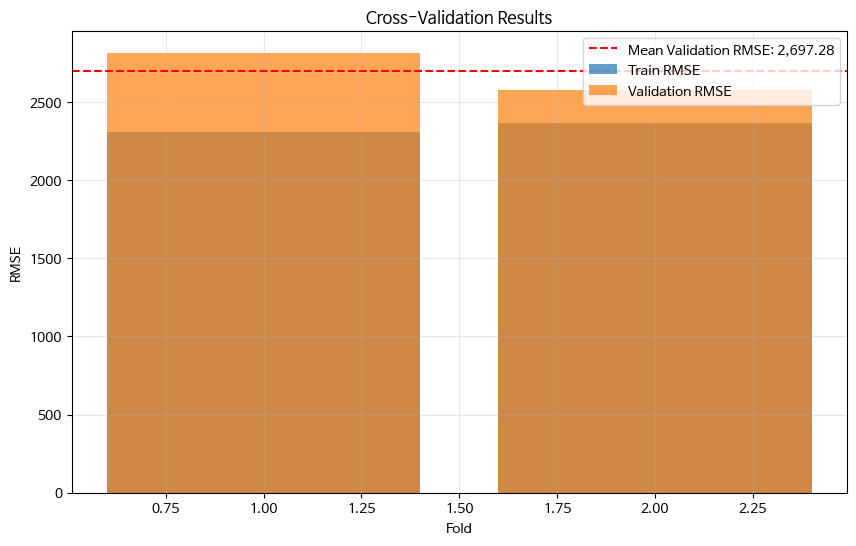

In [78]:
#############################################################
# 6. MODEL TRAINING (Stratified K-fold)
#############################################################

# Lists to store fold results
cv_train_rmse = []
cv_val_rmse = []
cv_models = []

# Perform cross-validation
print(f"Starting {n_folds}-fold cross-validation...")

for fold, (train_idx, val_idx) in enumerate(fold_indices):
    print(f"\nFold {fold+1}/{n_folds}")
    
    # Split data for this fold
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]
    
    # Preprocess data for this fold
    fold_data = preprocess_fold_data(X_train_fold, y_train_fold, X_val_fold, y_val_fold)

    # Define XGBoost model
    model_fold  = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        early_stopping_rounds=100,
        reg_alpha=0.001,
        reg_lambda=0,
        random_state=42,
        tree_method='gpu_hist' if xgb.config.get_config().get('use_gpu', False) else 'hist',
        predictor='gpu_predictor',  
    )


    # Train the model
    model_fold.fit(
        fold_data['X_train'], fold_data['y_train_log'],
        eval_set=[(fold_data['X_train'], fold_data['y_train_log']), 
                  (fold_data['X_val'], fold_data['y_val_log'])],
        verbose=100
    )
    
    # Save trained model and preprocessing info
    cv_models.append({
        'model': model_fold,
        'feature_scaler': fold_data['feature_scaler'],
        'label_encoders': fold_data['label_encoders'],
        'offset': fold_data['offset']
    })
    
    # Make predictions
    train_pred_log = model_fold.predict(fold_data['X_train'])
    val_pred_log = model_fold.predict(fold_data['X_val'])
    
    # Convert to original scale
    train_pred_orig = np.expm1(train_pred_log) - fold_data['offset']
    val_pred_orig = np.expm1(val_pred_log) - fold_data['offset']
    
    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(fold_data['y_train_orig'], train_pred_orig))
    val_rmse = np.sqrt(mean_squared_error(fold_data['y_val_orig'], val_pred_orig))
    
    # Store results
    cv_train_rmse.append(train_rmse)
    cv_val_rmse.append(val_rmse)
    
    # Print results for this fold
    print(f"Fold {fold+1} Train RMSE: {train_rmse:,.2f}")
    print(f"Fold {fold+1} Validation RMSE: {val_rmse:,.2f}")

# Find best model (based on validation RMSE)
best_model_idx = np.argmin(cv_val_rmse)
best_model_info = cv_models[best_model_idx]

# Print overall cross-validation results
print("\nCross-Validation Results:")
print(f"Average Train RMSE: {np.mean(cv_train_rmse):,.2f} (±{np.std(cv_train_rmse):,.2f})")
print(f"Average Validation RMSE: {np.mean(cv_val_rmse):,.2f} (±{np.std(cv_val_rmse):,.2f})")
print(f"Best model from fold {best_model_idx+1} with validation RMSE: {cv_val_rmse[best_model_idx]:,.2f}")

# Visualize cross-validation results
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_folds+1), cv_train_rmse, alpha=0.7, label='Train RMSE')
plt.bar(range(1, n_folds+1), cv_val_rmse, alpha=0.7, label='Validation RMSE')
plt.axhline(y=np.mean(cv_val_rmse), color='r', linestyle='--', 
            label=f'Mean Validation RMSE: {np.mean(cv_val_rmse):,.2f}')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Cross-Validation Results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(OUTPUT_PATH+'cv_results_transportation_features.png')
plt.show()

#### Plot learning curves

#### 7. MODEL EVALUATION


=== Cross-Validation Performance Analysis ===
Average Train RMSE: 2,335.47 (±29.11)
Average Validation RMSE: 2,697.28 (±118.66)
Best model from fold 2 with validation RMSE: 2,578.62
Train RMSE coefficient of variation: 1.25%
Validation RMSE coefficient of variation: 4.40%


/tmp/ipykernel_124237/1051349184.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cv_train_rmse, cv_val_rmse], labels=['Train RMSE', 'Validation RMSE'])


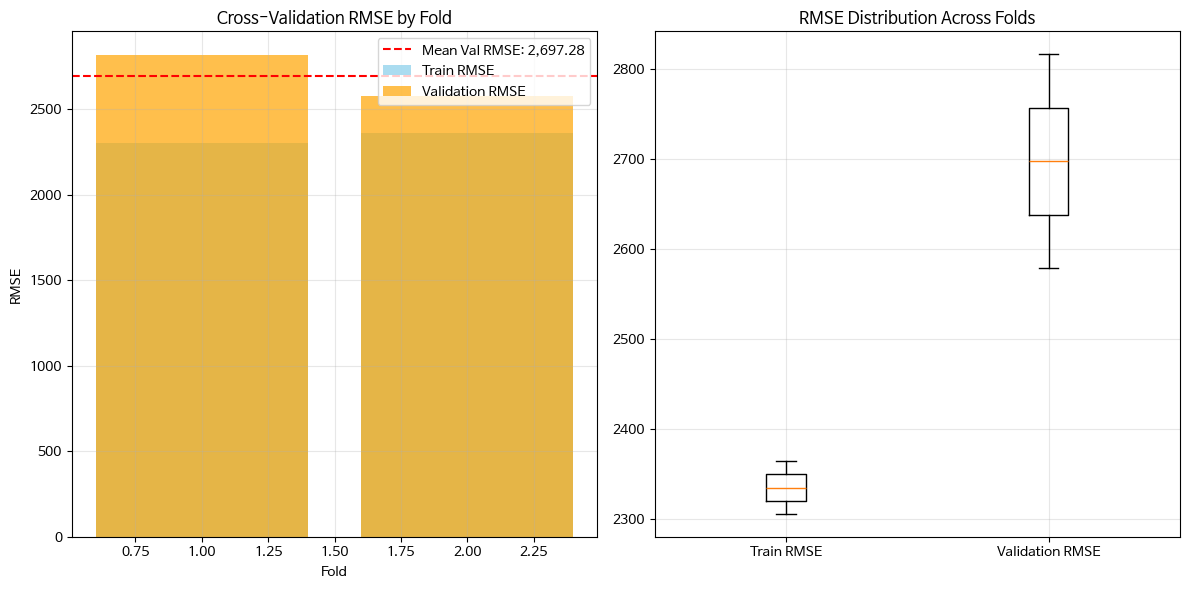


=== Best Model Analysis ===
Selected 7 important transportation features
Best model Train RMSE: 2,364.58
Best model Validation RMSE: 2,578.62


/tmp/ipykernel_124237/1051349184.py:97: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/tmp/ipykernel_124237/1051349184.py:98: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.savefig(OUTPUT_PATH+'best_model_analysis.png')
/data/ephemeral/home/miniconda3/envs/py39-rapids-env1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


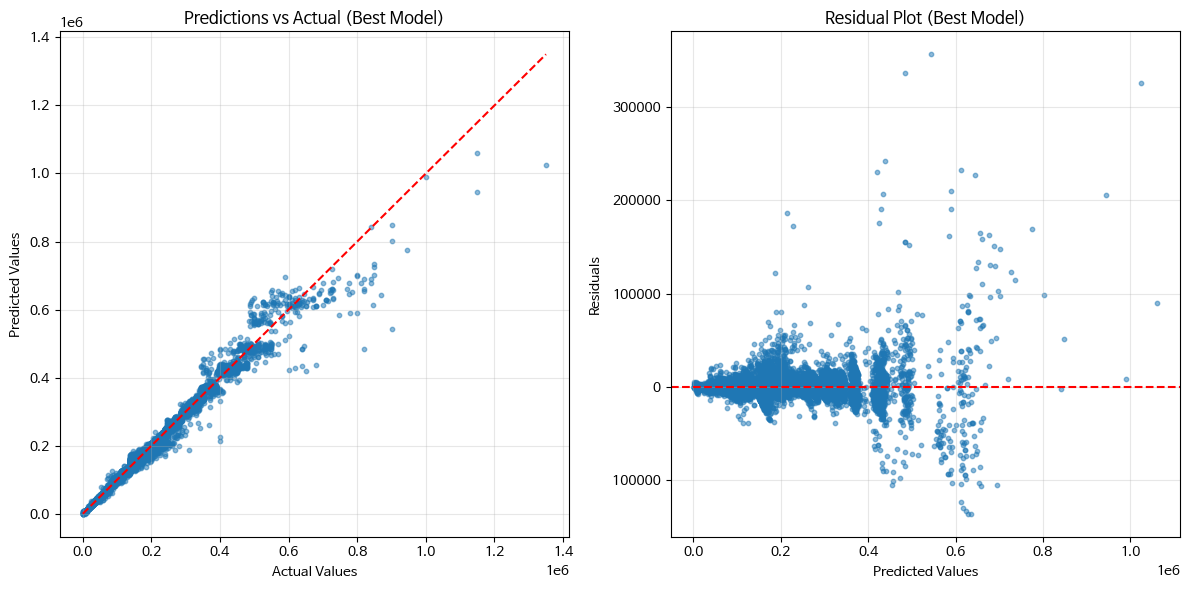


=== Feature Importance Analysis ===
Top 10 Most Important Features:
                     Feature  Importance
77   price_per_transit_score    0.277065
78  area_transit_interaction    0.145604
56           transit_quality    0.111393
55             transit_score    0.064799
57               near_subway    0.057879
47       subway_stations_1km    0.055209
4                       전용면적    0.041142
73                       계약년    0.030026
40                       좌표Y    0.025177
43   nearest_subway_distance    0.022961


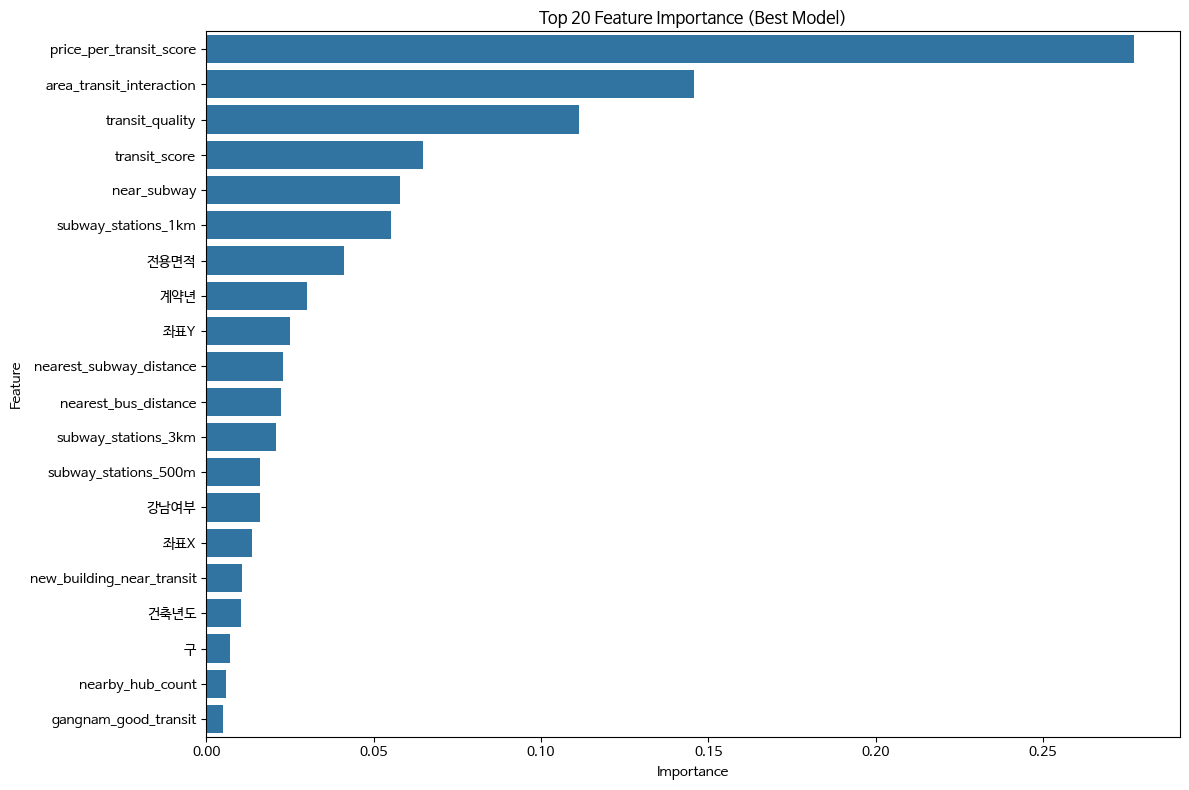

Number of features needed for 90% of total importance: 14


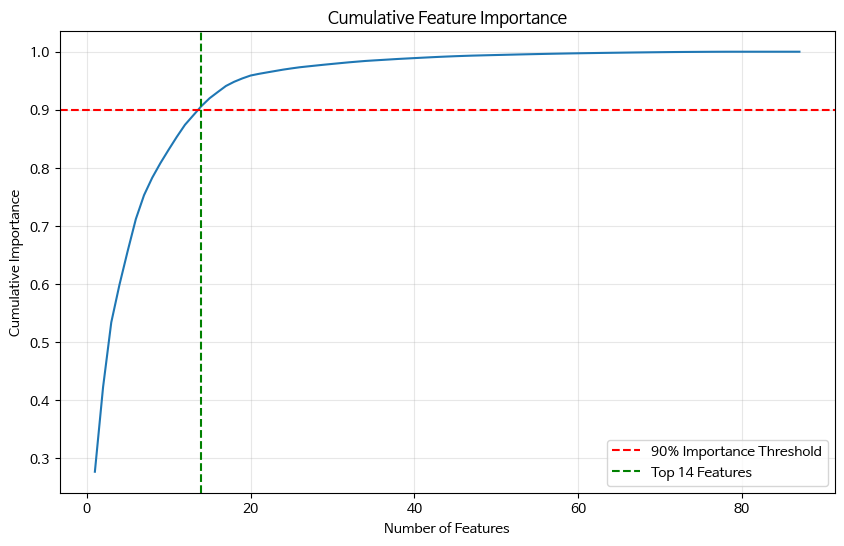

In [79]:

# 7.1 Cross-Validation Performance Analysis
print("\n=== Cross-Validation Performance Analysis ===")

# Calculate average and std dev of CV results
mean_train_rmse = np.mean(cv_train_rmse)
std_train_rmse = np.std(cv_train_rmse)
mean_val_rmse = np.mean(cv_val_rmse)
std_val_rmse = np.std(cv_val_rmse)

# Print summary statistics
print(f"Average Train RMSE: {mean_train_rmse:,.2f} (±{std_train_rmse:,.2f})")
print(f"Average Validation RMSE: {mean_val_rmse:,.2f} (±{std_val_rmse:,.2f})")
print(f"Best model from fold {best_model_idx+1} with validation RMSE: {cv_val_rmse[best_model_idx]:,.2f}")

# Calculate the coefficient of variation (CV) to assess stability
cv_train = std_train_rmse / mean_train_rmse * 100
cv_val = std_val_rmse / mean_val_rmse * 100
print(f"Train RMSE coefficient of variation: {cv_train:.2f}%")
print(f"Validation RMSE coefficient of variation: {cv_val:.2f}%")

# Visualize cross-validation results as bar chart
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, n_folds+1), cv_train_rmse, alpha=0.7, label='Train RMSE', color='skyblue')
plt.bar(range(1, n_folds+1), cv_val_rmse, alpha=0.7, label='Validation RMSE', color='orange')
plt.axhline(y=mean_val_rmse, color='r', linestyle='--', 
            label=f'Mean Val RMSE: {mean_val_rmse:,.2f}')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Cross-Validation RMSE by Fold')
plt.legend()
plt.grid(True, alpha=0.3)

# Visualize train vs validation RMSE distribution as boxplot
plt.subplot(1, 2, 2)
plt.boxplot([cv_train_rmse, cv_val_rmse], labels=['Train RMSE', 'Validation RMSE'])
plt.title('RMSE Distribution Across Folds')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_PATH+'cv_performance_analysis.png')
plt.show()

# 7.2 Best Model Analysis
print("\n=== Best Model Analysis ===")

# Get the best model and its parameters
best_model = best_model_info['model']
best_feature_scaler = best_model_info['feature_scaler']
best_label_encoders = best_model_info['label_encoders']
best_offset = best_model_info['offset']

# Get train and validation indices for the best fold
best_train_idx, best_val_idx = fold_indices[best_model_idx]
X_best_train = X_train.iloc[best_train_idx]
y_best_train = y_train.iloc[best_train_idx]
X_best_val = X_train.iloc[best_val_idx]
y_best_val = y_train.iloc[best_val_idx]

# Reapply preprocessing to get proper evaluation data
best_fold_data = preprocess_fold_data(X_best_train, y_best_train, X_best_val, y_best_val)

# Make predictions with the best model
best_train_pred_log = best_model.predict(best_fold_data['X_train'])
best_val_pred_log = best_model.predict(best_fold_data['X_val'])

# Convert to original scale
best_train_pred_orig = np.expm1(best_train_pred_log) - best_offset
best_val_pred_orig = np.expm1(best_val_pred_log) - best_offset

# Calculate final RMSE on best model's fold
best_train_rmse = np.sqrt(mean_squared_error(best_fold_data['y_train_orig'], best_train_pred_orig))
best_val_rmse = np.sqrt(mean_squared_error(best_fold_data['y_val_orig'], best_val_pred_orig))
print(f"Best model Train RMSE: {best_train_rmse:,.2f}")
print(f"Best model Validation RMSE: {best_val_rmse:,.2f}")

# Plot actual vs predicted for validation set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(best_fold_data['y_val_orig'], best_val_pred_orig, alpha=0.5, s=10)
plt.plot([best_fold_data['y_val_orig'].min(), best_fold_data['y_val_orig'].max()], 
         [best_fold_data['y_val_orig'].min(), best_fold_data['y_val_orig'].max()], 
         'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual (Best Model)')
plt.grid(True, alpha=0.3)

# Plot residuals
residuals = best_fold_data['y_val_orig'] - best_val_pred_orig
plt.subplot(1, 2, 2)
plt.scatter(best_val_pred_orig, residuals, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Best Model)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_PATH+'best_model_analysis.png')
plt.show()

# 7.3 Feature Importance Analysis
print("\n=== Feature Importance Analysis ===")

# Get feature importance from best model
importance = best_model.feature_importances_
feature_names = best_fold_data['X_train'].columns

# Create DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print top 10 features
print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importance (Best Model)')
plt.tight_layout()
plt.savefig(OUTPUT_PATH+'feature_importance.png')
plt.show()

# Calculate cumulative importance
importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum()
num_features_90pct = sum(importance_df['Cumulative_Importance'] <= 0.9) + 1
print(f"Number of features needed for 90% of total importance: {num_features_90pct}")

# Cumulative importance plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(importance_df) + 1), importance_df['Cumulative_Importance'])
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Importance Threshold')
plt.axvline(x=num_features_90pct, color='g', linestyle='--', 
            label=f'Top {num_features_90pct} Features')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(OUTPUT_PATH+'cumulative_importance.png')
plt.show()

#### 7.1 ERROR ANALYSIS VISUALIZATION


=== Error Analysis Visualization ===


=== Error Statistics ===
Mean Absolute Error: 678.50
Median Absolute Error: 293.83
Mean Percentage Error: 1.00%
Median Percentage Error: 0.70%
Overpredictions: 278816 (33.2%)
Underpredictions: 280589 (33.4%)


/tmp/ipykernel_124237/4179811236.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Worst 100 Predictions', 'Best 100 Predictions'])
/tmp/ipykernel_124237/4179811236.py:101: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/tmp/ipykernel_124237/4179811236.py:102: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.savefig(OUTPUT_PATH+'error_analysis.png')
/data/ephemeral/home/miniconda3/envs/py39-rapids-env1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


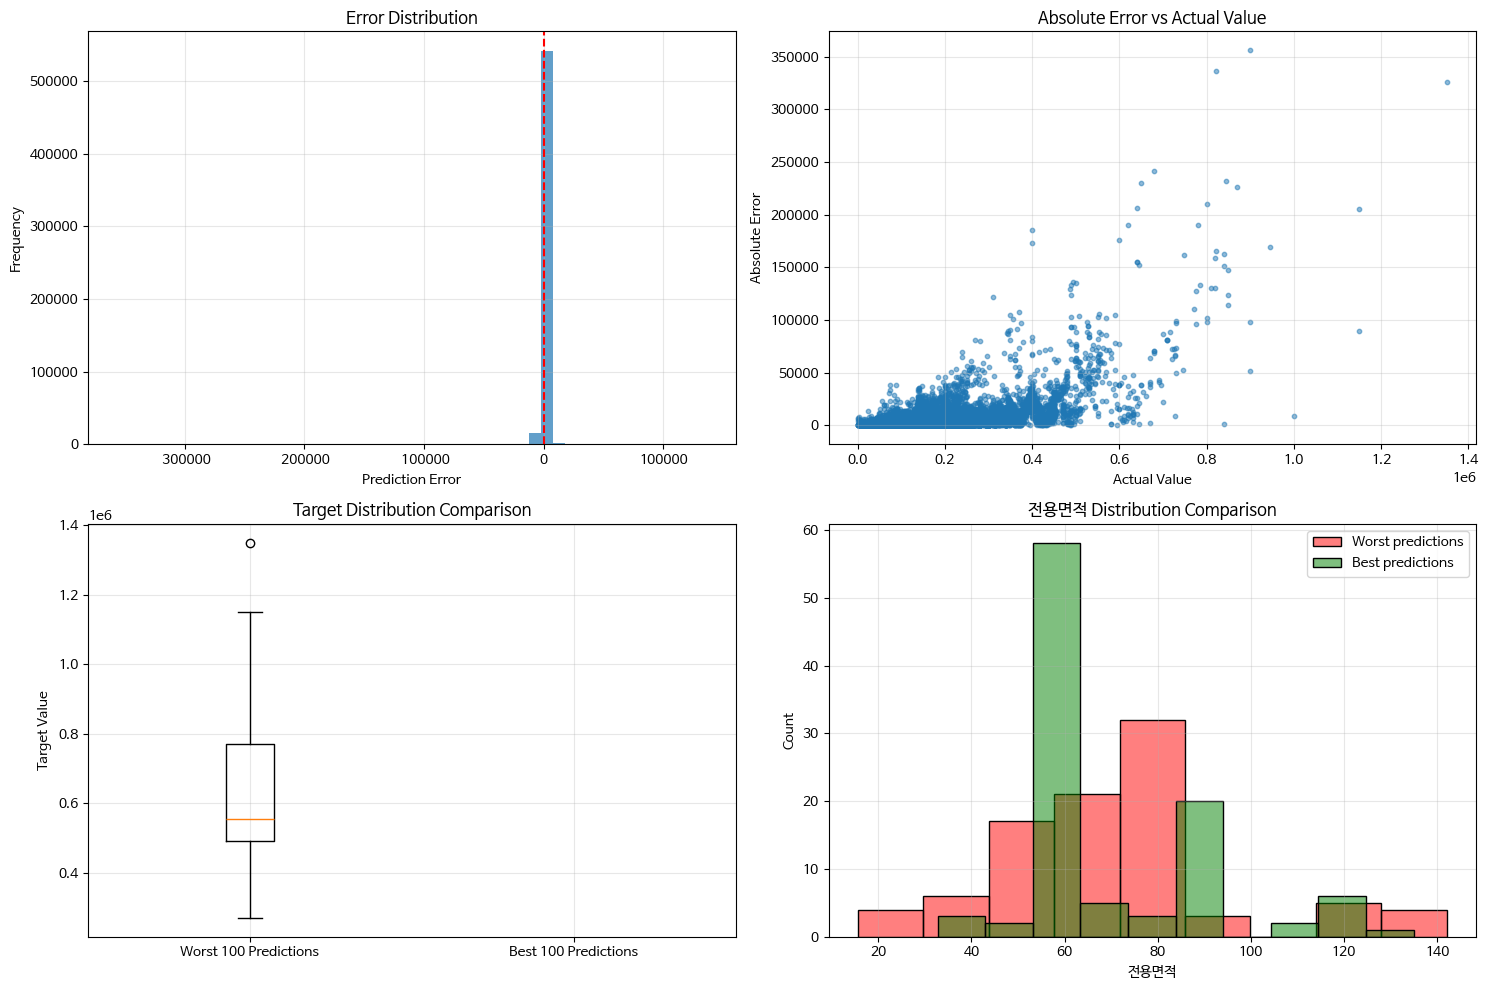


=== Features Related to High Error ===
Top 10 Features Most Correlated with Prediction Error:
                     Feature  Correlation
0              transit_score     0.019716
1                near_subway     0.019468
2        near_public_transit     0.019468
3    nearest_subway_distance     0.019025
4        subway_stations_3km     0.018111
5  new_building_near_transit     0.017611
6                       신축여부     0.015698
7                  k-관리비부과면적     0.015111
8             near_major_hub     0.015053
9                      k-연면적     0.014969


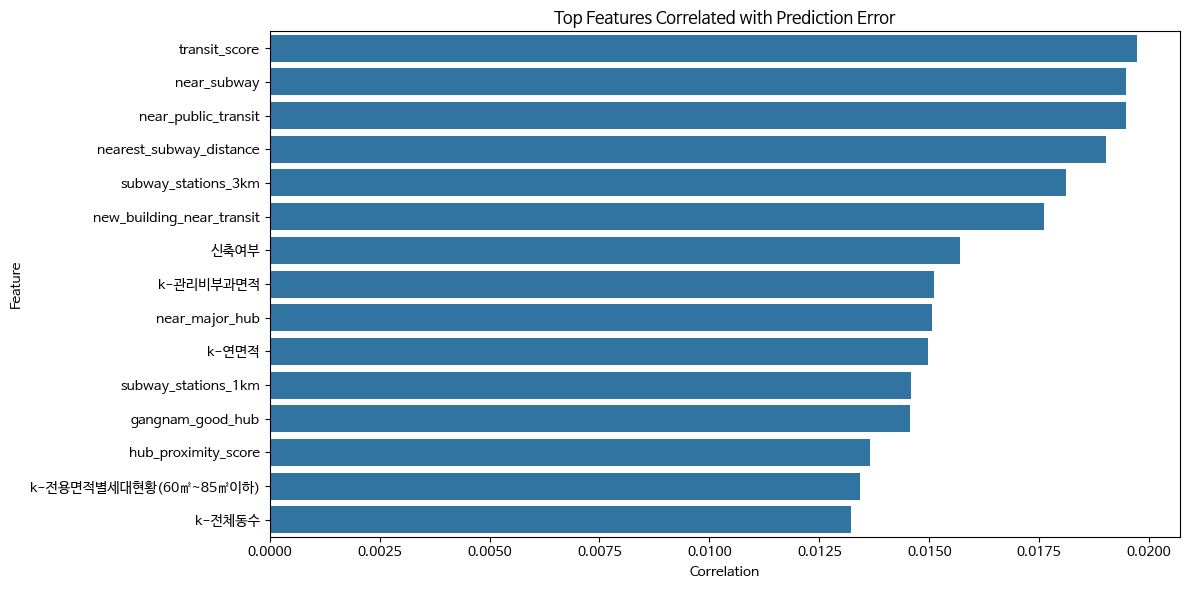

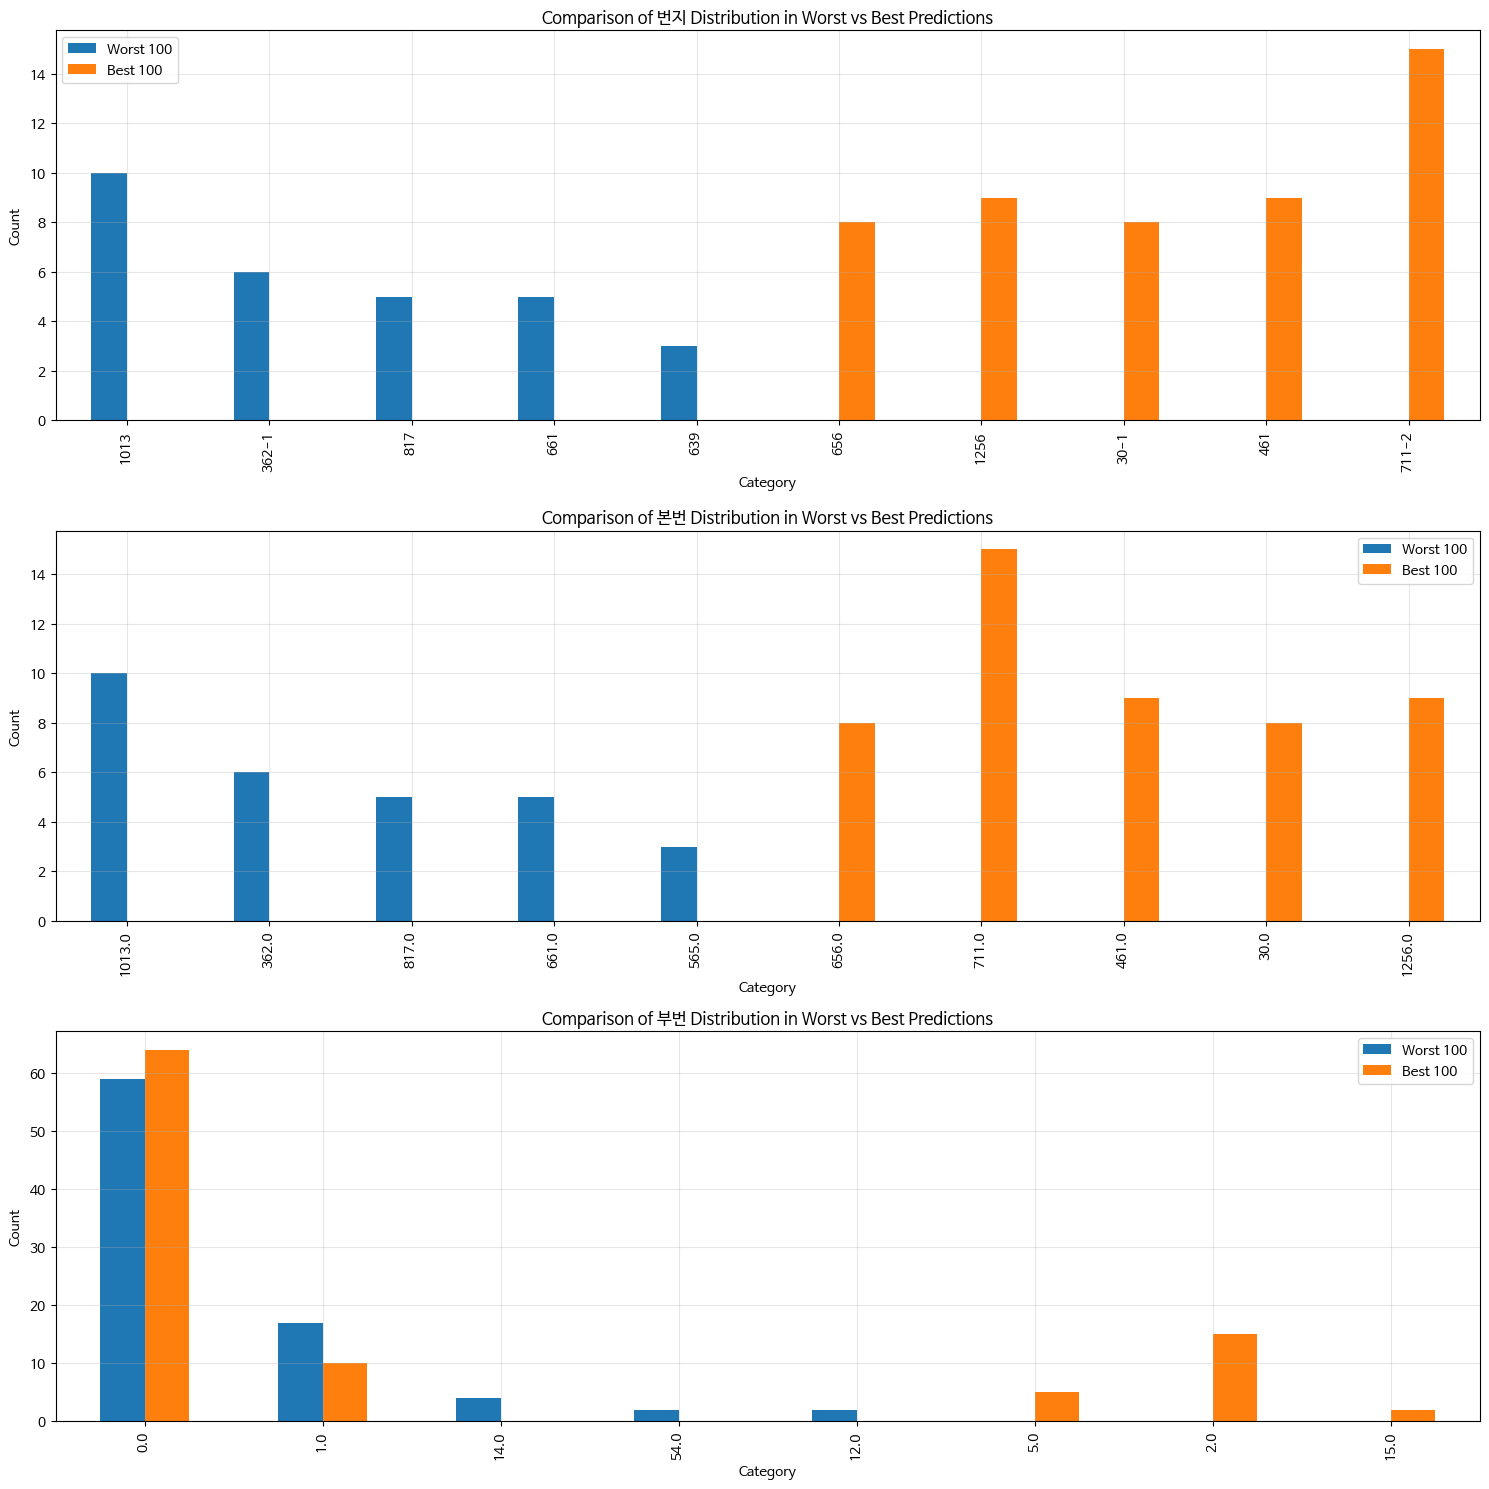

In [80]:
#############################################################
# 7.1 ERROR ANALYSIS VISUALIZATION
#############################################################
print("\n=== Error Analysis Visualization ===")

# We'll analyze the errors from the best model's validation set
# Create a DataFrame with predictions for analysis
analysis_df = pd.DataFrame({
    'actual': best_fold_data['y_val_orig'],
    'predicted': best_val_pred_orig,
})

# Calculate error metrics
analysis_df['error'] = analysis_df['predicted'] - analysis_df['actual']
analysis_df['abs_error'] = np.abs(analysis_df['error'])
analysis_df['squared_error'] = analysis_df['error'] ** 2
analysis_df['percent_error'] = 100 * np.abs(analysis_df['error'] / analysis_df['actual'])

# Merge with original features for analysis
X_best_val_orig = X_train.iloc[best_val_idx].reset_index(drop=True)
analysis_df = pd.concat([analysis_df, X_best_val_orig], axis=1)

# Sort by squared error descending
analysis_df_sorted = analysis_df.sort_values('squared_error', ascending=False)

# Get worst and best 100 predictions
worst_100 = analysis_df_sorted.head(100)
best_100 = analysis_df_sorted.tail(100)

# Inverse transform categorical columns for better interpretation
worst_100_decoded = worst_100.copy()
best_100_decoded = best_100.copy()

# Function to decode all categorical columns from a DataFrame
def decode_categorical_columns(df, encoders, cat_cols):
    df_decoded = df.copy()
    for col in cat_cols:
        if col in df.columns and col in encoders:
            try:
                df_decoded[col] = encoders[col].inverse_transform(df[col].astype(int))
            except:
                pass  # Skip if there's an error
    return df_decoded

# Apply decoding
worst_100_decoded = decode_categorical_columns(worst_100, best_label_encoders, categorical_columns)
best_100_decoded = decode_categorical_columns(best_100, best_label_encoders, categorical_columns)

# Basic error statistics
print("=== Error Statistics ===")
print(f"Mean Absolute Error: {analysis_df['abs_error'].mean():,.2f}")
print(f"Median Absolute Error: {analysis_df['abs_error'].median():,.2f}")
print(f"Mean Percentage Error: {analysis_df['percent_error'].mean():,.2f}%")
print(f"Median Percentage Error: {analysis_df['percent_error'].median():,.2f}%")

# Direction of errors
overpredict = (analysis_df['error'] > 0).sum()
underpredict = (analysis_df['error'] < 0).sum()
print(f"Overpredictions: {overpredict} ({overpredict/len(analysis_df)*100:.1f}%)")
print(f"Underpredictions: {underpredict} ({underpredict/len(analysis_df)*100:.1f}%)")

# Error distribution visualization
plt.figure(figsize=(15, 10))

# 1. Error distribution histogram
plt.subplot(2, 2, 1)
plt.hist(analysis_df['error'], bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 2. Absolute error vs actual
plt.subplot(2, 2, 2)
plt.scatter(analysis_df['actual'], analysis_df['abs_error'], alpha=0.5, s=10)
plt.title('Absolute Error vs Actual Value')
plt.xlabel('Actual Value')
plt.ylabel('Absolute Error')
plt.grid(True, alpha=0.3)

# 3. Box plot comparing worst and best predictions
plt.subplot(2, 2, 3)
data_to_plot = [worst_100['actual'], best_100['actual']]
plt.boxplot(data_to_plot, labels=['Worst 100 Predictions', 'Best 100 Predictions'])
plt.title('Target Distribution Comparison')
plt.ylabel('Target Value')
plt.grid(True, alpha=0.3)

# 4. Feature comparison for worst vs best predictions
# Select a key feature (e.g., area, which is often important for real estate)
key_feature = '전용면적'  # Adjust this to a feature in your dataset
plt.subplot(2, 2, 4)
sns.histplot(worst_100[key_feature], alpha=0.5, label='Worst predictions', color='red')
sns.histplot(best_100[key_feature], alpha=0.5, label='Best predictions', color='green')
plt.title(f'{key_feature} Distribution Comparison')
plt.xlabel(key_feature)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH+'error_analysis.png')
plt.show()



# Feature importance for error prediction - simplified approach
print("\n=== Features Related to High Error ===")

# Instead of training a model, let's analyze correlations with error
numeric_cols = [col for col in X_best_val_orig.columns 
                if pd.api.types.is_numeric_dtype(X_best_val_orig[col])]

# Create a DataFrame for correlation analysis
error_corr_df = X_best_val_orig[numeric_cols].copy()
error_corr_df['abs_error'] = analysis_df['abs_error']

# Calculate correlation with absolute error
corr_with_error = []
for col in numeric_cols:
    try:
        # Skip columns with NaN or infinite values
        if error_corr_df[col].isna().any() or np.isinf(error_corr_df[col]).any():
            continue
            
        corr = error_corr_df[col].corr(error_corr_df['abs_error'])
        if not np.isnan(corr):
            corr_with_error.append((col, abs(corr)))
    except:
        # Skip columns that cause errors
        continue

# Sort by correlation strength
corr_with_error.sort(key=lambda x: x[1], reverse=True)

# Create results DataFrame
error_importance = pd.DataFrame(corr_with_error, columns=['Feature', 'Correlation'])

# Print top features correlated with high error
print("Top 10 Features Most Correlated with Prediction Error:")
print(error_importance.head(10))

# Plot top error-correlated features (if we have any)
if len(error_importance) > 0:
    plt.figure(figsize=(12, 6))
    top_n = min(15, len(error_importance))
    sns.barplot(x='Correlation', y='Feature', data=error_importance.head(top_n))
    plt.title('Top Features Correlated with Prediction Error')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH+'error_feature_correlation.png')
    plt.show()
else:
    print("No valid correlations found with prediction error.")


# Plot prediction error by key categorical variables
key_cat_vars = []
for col in categorical_columns:
    if col in worst_100_decoded.columns:
        try:
            # Count occurrences in worst and best predictions
            worst_counts = worst_100_decoded[col].value_counts().nlargest(5)
            best_counts = best_100_decoded[col].value_counts().nlargest(5)
            
            # If there's overlap and sufficient variety
            if len(set(worst_counts.index) | set(best_counts.index)) >= 3:
                key_cat_vars.append(col)
                
            # Limit to 3 categorical variables for visualization
            if len(key_cat_vars) >= 3:
                break
        except:
            continue

# If we found key categorical variables, plot them
if key_cat_vars:
    plt.figure(figsize=(15, 5 * len(key_cat_vars)))
    
    for i, col in enumerate(key_cat_vars):
        plt.subplot(len(key_cat_vars), 1, i+1)
        
        # Get counts from worst and best
        worst_counts = worst_100_decoded[col].value_counts().nlargest(5)
        best_counts = best_100_decoded[col].value_counts().nlargest(5)
        
        # Get unique categories across both
        all_cats = list(set(worst_counts.index) | set(best_counts.index))
        
        # Create comparison DataFrame
        comp_data = []
        for cat in all_cats:
            worst_count = worst_counts[cat] if cat in worst_counts else 0
            best_count = best_counts[cat] if cat in best_counts else 0
            comp_data.append({
                'Category': cat,
                'Worst 100': worst_count,
                'Best 100': best_count
            })
        
        comp_df = pd.DataFrame(comp_data)
        comp_df = comp_df.sort_values('Worst 100', ascending=False)
        
        # Plot as grouped bar chart
        comp_df.plot(x='Category', y=['Worst 100', 'Best 100'], kind='bar', ax=plt.gca())
        plt.title(f'Comparison of {col} Distribution in Worst vs Best Predictions')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('categorical_error_analysis.png')
    plt.show()

#### Section 7.3: TRANSPORTATION FEATURE ANALYSIS (New Section)


=== Transportation Feature Analysis ===
Analyzing transportation features...

=== Transportation Feature Analysis ===
Found 37 transportation-related features:
nearest_subway_distance, nearest_subway_name, nearest_subway_line, subway_stations_500m, subway_stations_1km, subway_stations_3km, nearest_bus_distance, nearest_bus_name, nearest_bus_type, bus_stops_300m, bus_stops_500m, bus_stops_1km, transit_score, transit_quality, near_subway, near_bus, near_public_transit, nearest_hub_id, nearest_hub_distance, nearest_hub_size, nearest_hub_type, nearest_major_hub_id, nearest_major_hub_distance, nearby_hub_count, hub_proximity_score, hub_quality, near_major_hub, multiple_hubs_nearby, price_per_transit_score, area_transit_interaction, new_building_near_transit, old_building_near_transit, gangnam_good_transit, high_floor_near_transit, area_hub_interaction, new_building_near_hub, gangnam_good_hub

Transportation Feature Importances:
- price_per_transit_score: 0.2771
- area_transit_interaction: 

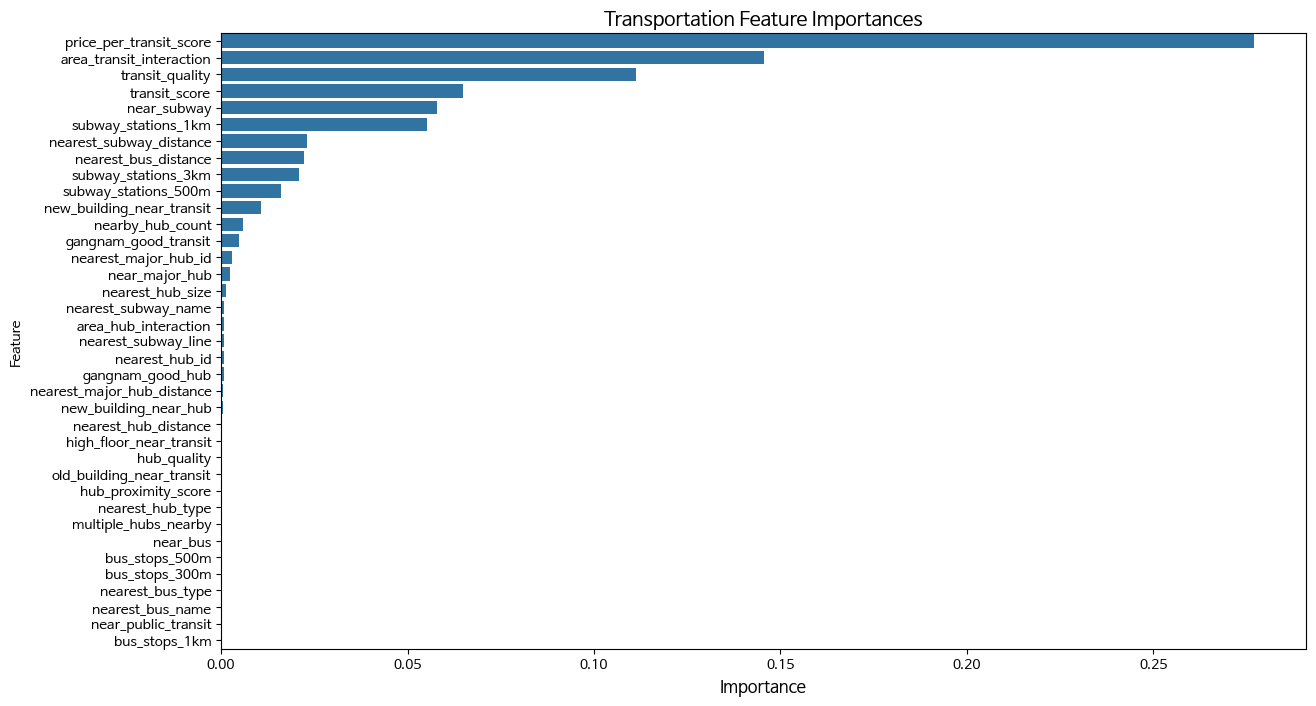

In [81]:
#############################################################
# 7.3 TRANSPORTATION FEATURE ANALYSIS (With Caching)
#############################################################
print("\n=== Transportation Feature Analysis ===")

# Cache directory for analysis results
analysis_cache_dir = os.path.join(CACHE_DIR, 'analysis')
os.makedirs(analysis_cache_dir, exist_ok=True)
analysis_cache_file = os.path.join(analysis_cache_dir, 'transport_feature_analysis.pkl')

# Check if analysis is already cached
if os.path.exists(analysis_cache_file):
    print(f"Loading cached transportation feature analysis from {analysis_cache_file}")
    with open(analysis_cache_file, 'rb') as f:
        transport_analysis = pickle.load(f)
        
    # Display cached analysis
    for key, value in transport_analysis.items():
        if isinstance(value, pd.DataFrame):
            print(f"\n{key}:")
            display(value.head())
        else:
            print(f"\n{key}: {value}")
else:
    # Perform analysis and cache results
    print("Analyzing transportation features...")


#############################################################
# 7.3 TRANSPORTATION FEATURE ANALYSIS (Enhanced)
#############################################################
print("\n=== Transportation Feature Analysis ===")

# Identify transportation features - be more comprehensive
transport_cols = [col for col in feature_names if any(term in col for term in 
                                                   ['subway', 'bus', 'transit', 'hub', 'public_transit', 
                                                    'accessibility'])]

if transport_cols:
    print(f"Found {len(transport_cols)} transportation-related features:")
    print(", ".join(transport_cols))
    
    # Extract transportation feature importances from the best model
    transport_importances = importance_df[importance_df['Feature'].isin(transport_cols)]
    transport_importances = transport_importances.sort_values('Importance', ascending=False)
    
    # Print importance of transportation features
    print("\nTransportation Feature Importances:")
    for _, row in transport_importances.iterrows():
        print(f"- {row['Feature']}: {row['Importance']:.4f}")
    
    # Calculate percent of total importance from transportation features
    total_importance = importance_df['Importance'].sum()
    transport_importance = transport_importances['Importance'].sum()
    importance_percent = (transport_importance / total_importance) * 100
    
    print(f"\nTransportation features contribute {importance_percent:.2f}% of total feature importance")
    
    # Visualize top transportation features
    plt.figure(figsize=(14, 8))
    
    # Plot all transportation features
    ax = sns.barplot(x='Importance', y='Feature', data=transport_importances)
    plt.title('Transportation Feature Importances', fontsize=14)
    plt.xlabel('Importance', fontsize=12)

#### Section 7.4: ADVANCED TRANSPORTATION IMPACT ANALYSIS


=== Advanced Transportation Impact Analysis ===
Analysis data prepared with 37 transportation features


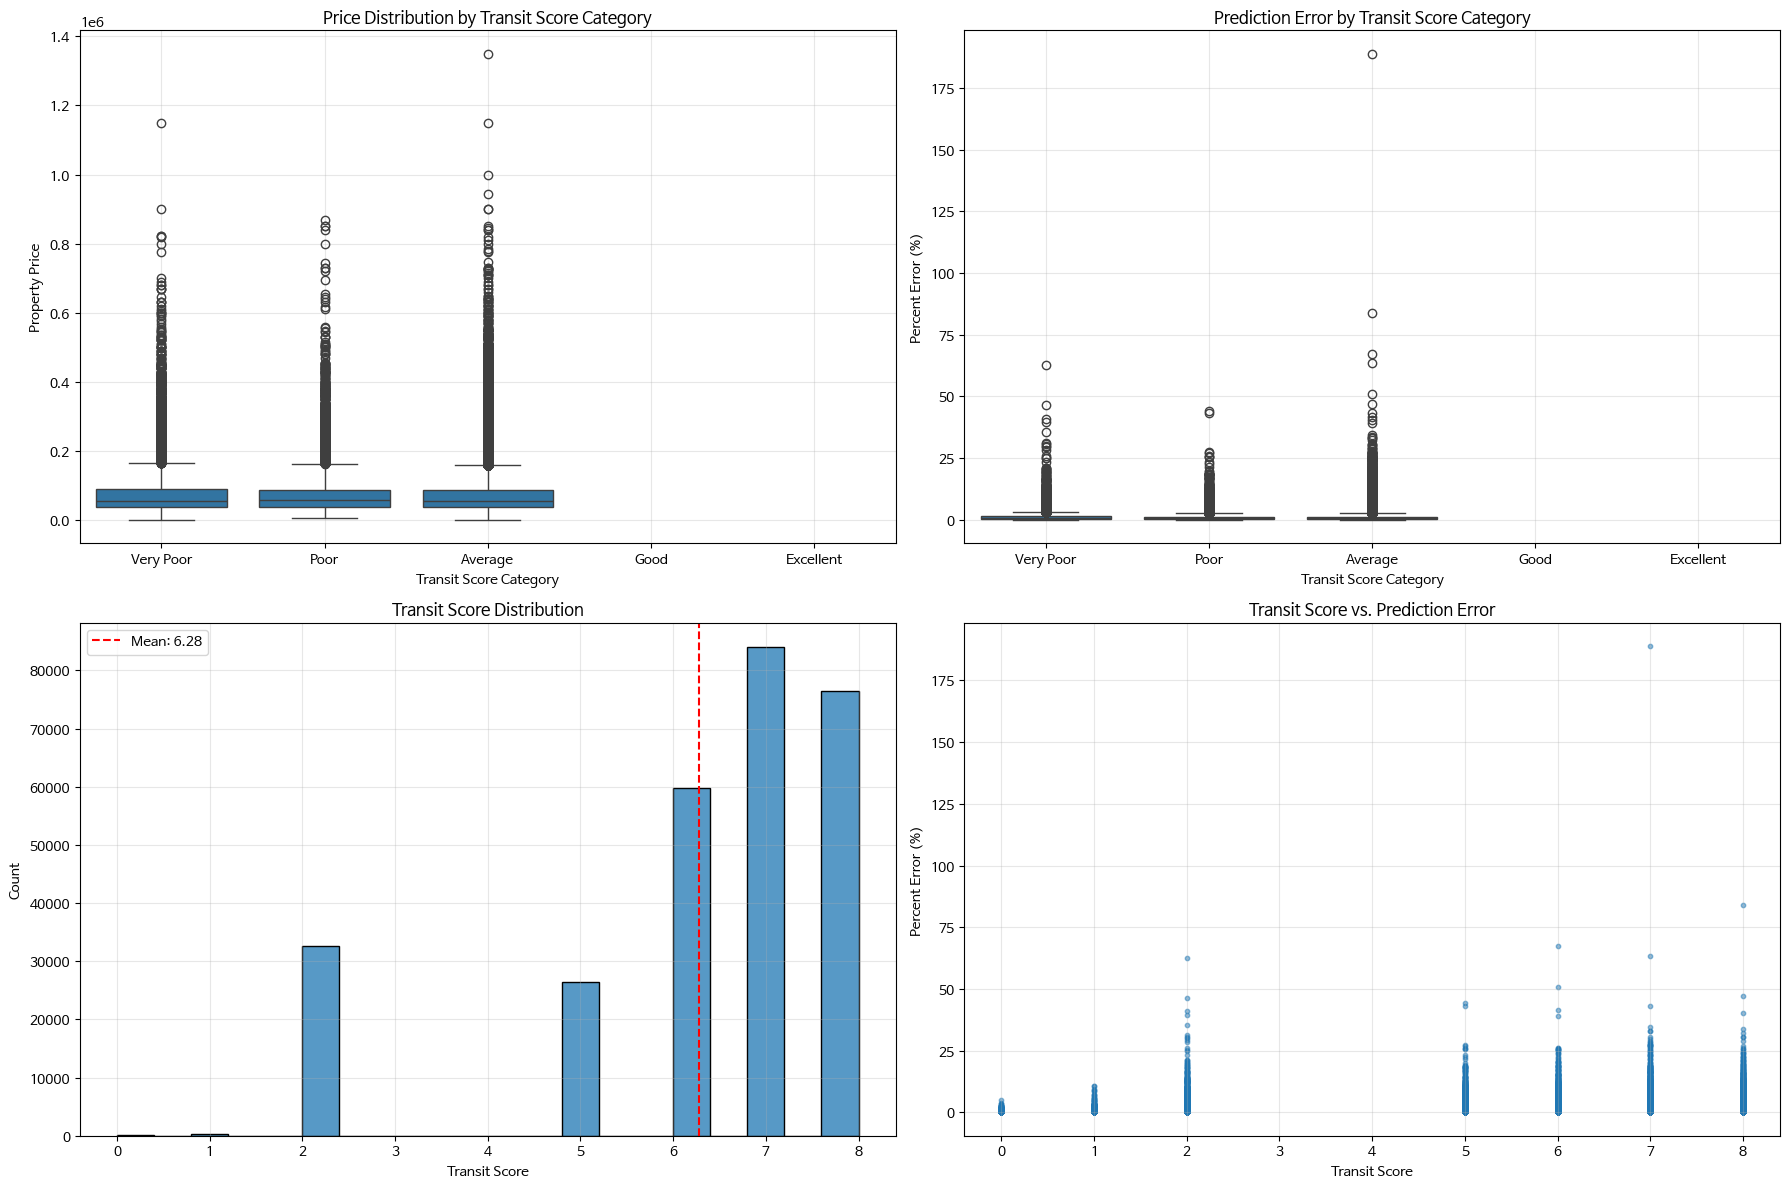

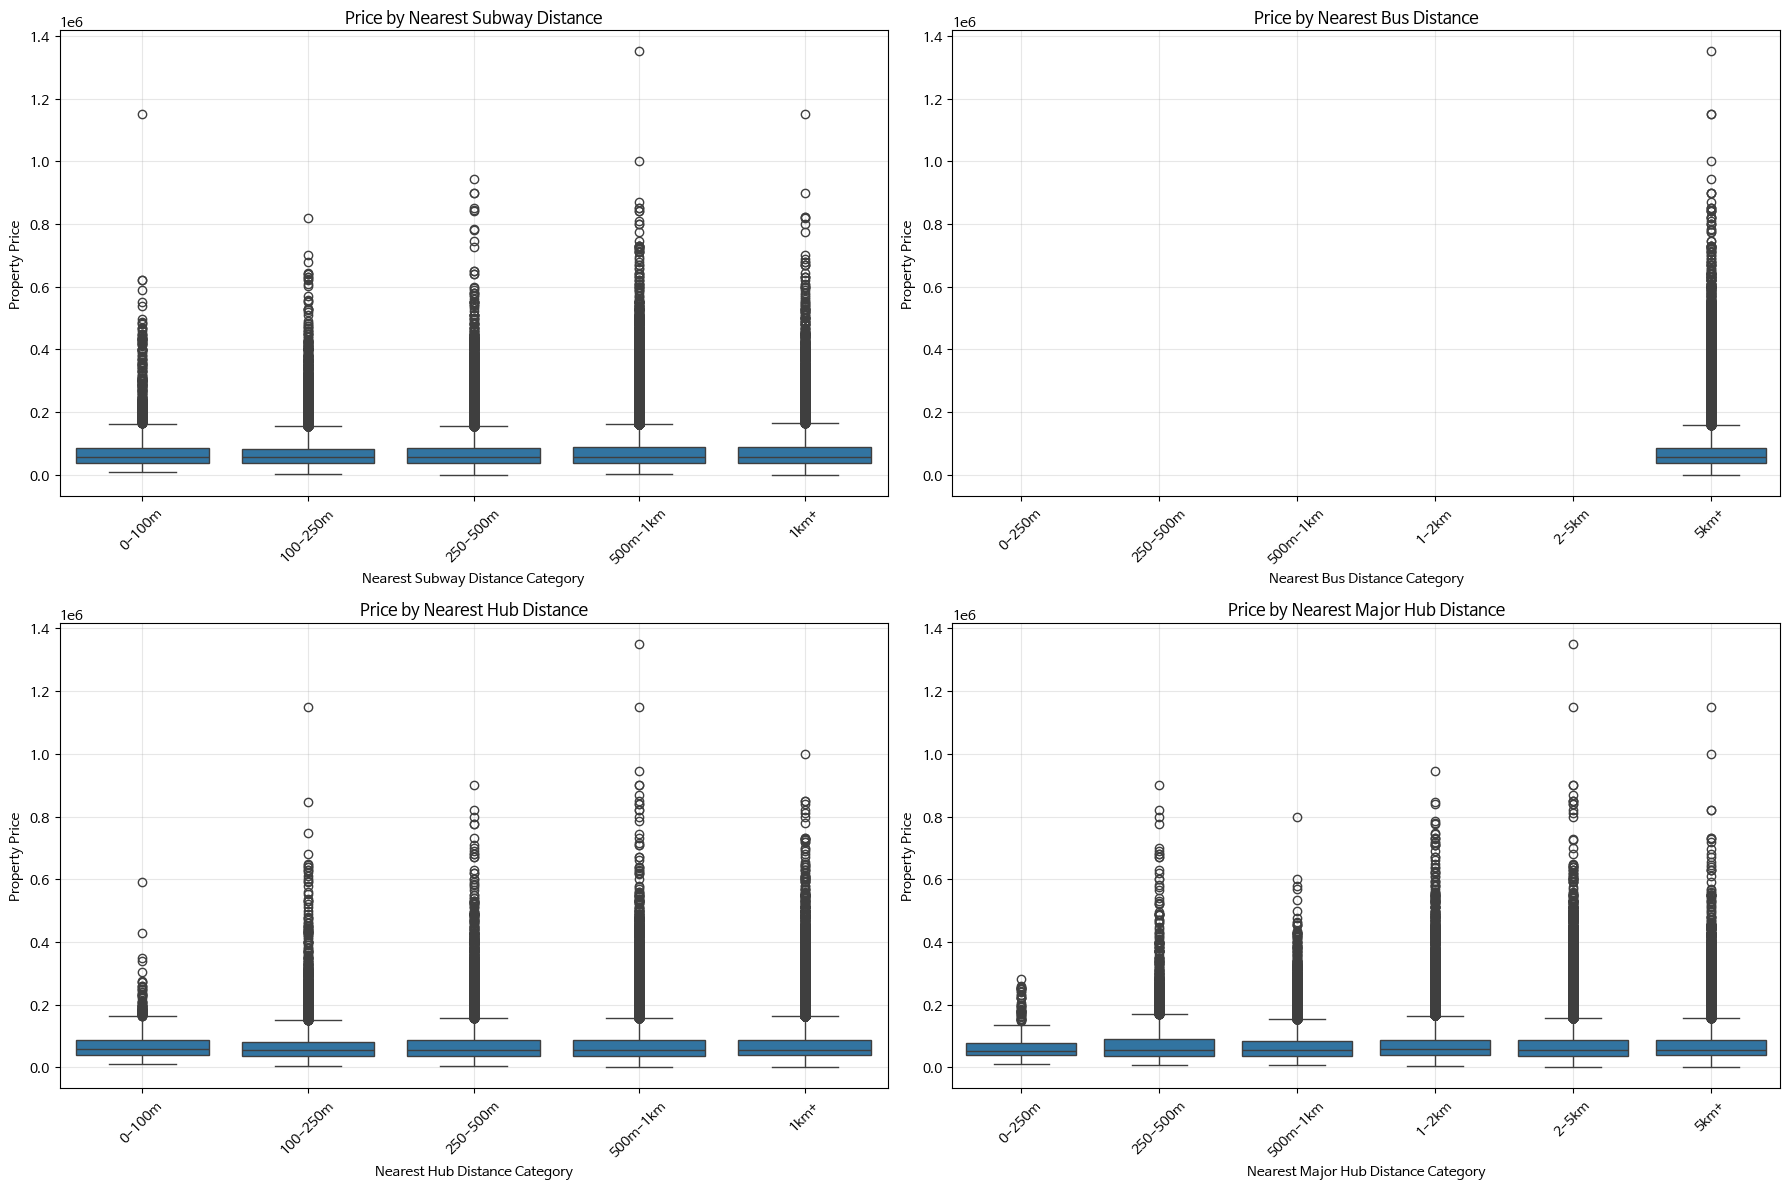

/tmp/ipykernel_124237/603366962.py:160: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/tmp/ipykernel_124237/603366962.py:161: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.savefig('./outputs/station_density_analysis.png')
/data/ephemeral/home/miniconda3/envs/py39-rapids-env1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


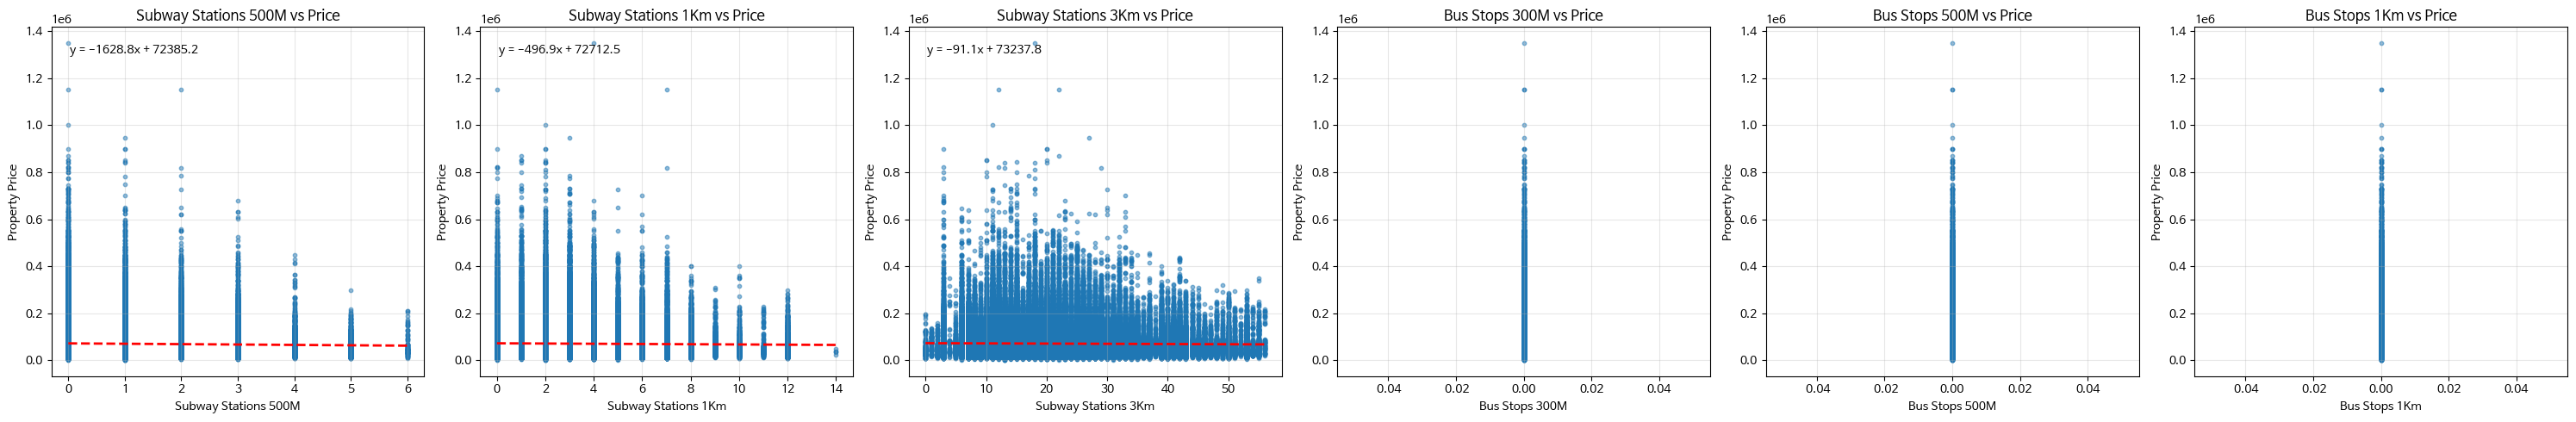

/data/ephemeral/home/miniconda3/envs/py39-rapids-env1/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
/tmp/ipykernel_124237/603366962.py:188: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.savefig('./outputs/transport_correlation.png')
/data/ephemeral/home/miniconda3/envs/py39-rapids-env1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


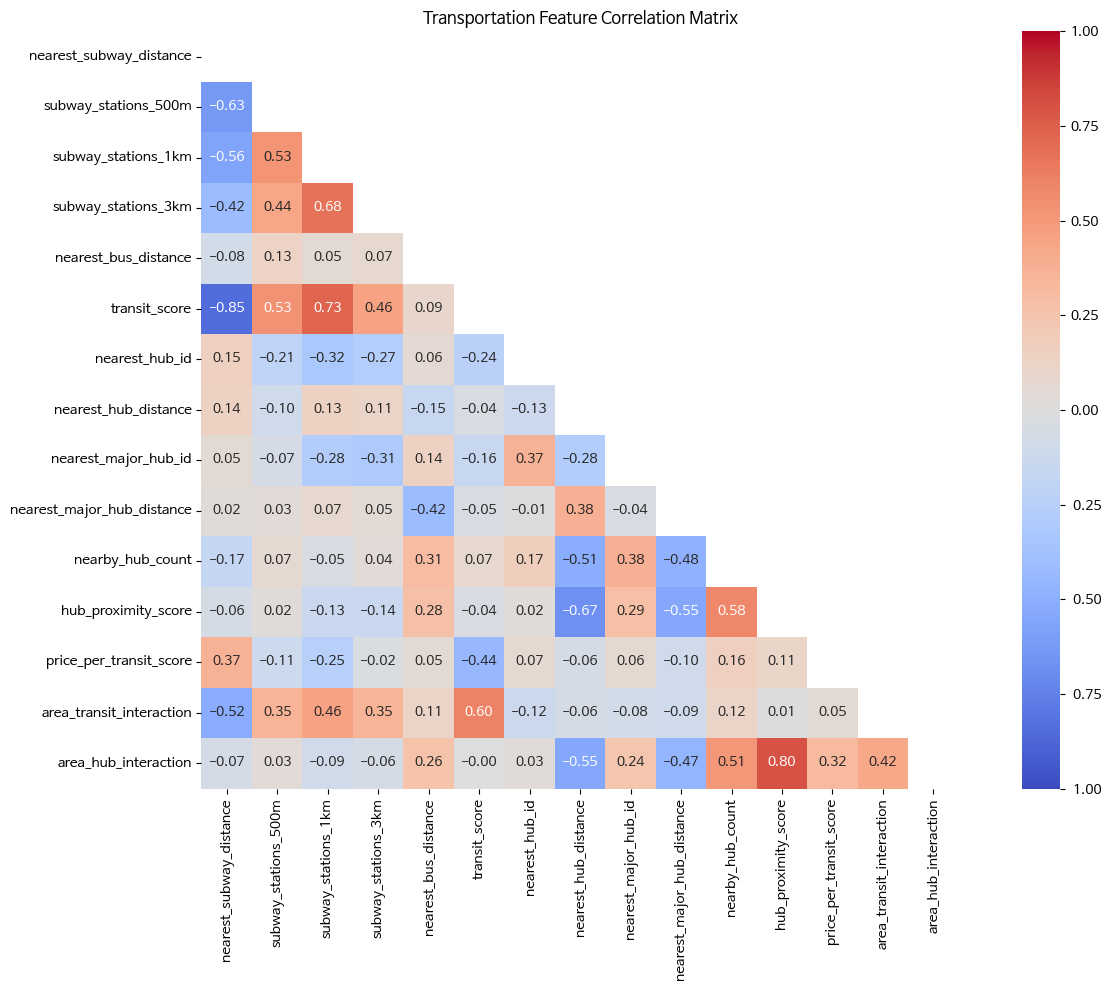

Not enough data points in each transit quality category for meaningful analysis


<Figure size 1200x600 with 0 Axes>

In [82]:
#############################################################
# 7.4 ADVANCED TRANSPORTATION IMPACT ANALYSIS
#############################################################
print("\n=== Advanced Transportation Impact Analysis ===")

# Identify all available transportation-related features
transport_features = [col for col in X_train.columns if any(term in col for term in 
                                                         ['subway', 'bus', 'transit', 'hub'])]

if transport_features:
    # Create analysis dataset
    analysis_data = pd.DataFrame({
        'actual': best_fold_data['y_val_orig'],
        'predicted': best_val_pred_orig,
        'error': np.abs(best_val_pred_orig - best_fold_data['y_val_orig']),
        'percent_error': 100 * np.abs((best_val_pred_orig - best_fold_data['y_val_orig']) / best_fold_data['y_val_orig'])
    })
    
    # Add the key transportation features to our analysis dataset
    X_best_val_reset = X_best_val.reset_index(drop=True)
    for feature in transport_features:
        if feature in X_best_val_reset.columns:
            analysis_data[feature] = X_best_val_reset[feature]
    
    print(f"Analysis data prepared with {len(transport_features)} transportation features")
    
    # 1. Transit Score Analysis
    if 'transit_score' in analysis_data.columns:
        plt.figure(figsize=(18, 12))
        
        # Create transit score categories for analysis
        score_bins = [0, 2, 5, 8, 15, float('inf')]
        score_labels = ['Very Poor', 'Poor', 'Average', 'Good', 'Excellent']
        analysis_data['transit_category'] = pd.cut(
            analysis_data['transit_score'], bins=score_bins, labels=score_labels)
        
        # Plot 1: Price distribution by transit score category
        plt.subplot(2, 2, 1)
        sns.boxplot(x='transit_category', y='actual', data=analysis_data)
        plt.title('Price Distribution by Transit Score Category')
        plt.xlabel('Transit Score Category')
        plt.ylabel('Property Price')
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Prediction error by transit score category
        plt.subplot(2, 2, 2)
        sns.boxplot(x='transit_category', y='percent_error', data=analysis_data)
        plt.title('Prediction Error by Transit Score Category')
        plt.xlabel('Transit Score Category')
        plt.ylabel('Percent Error (%)')
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Transit score distribution
        plt.subplot(2, 2, 3)
        sns.histplot(data=analysis_data, x='transit_score', bins=20)
        plt.axvline(x=analysis_data['transit_score'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {analysis_data["transit_score"].mean():.2f}')
        plt.legend()
        plt.title('Transit Score Distribution')
        plt.xlabel('Transit Score')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)
        
        # Plot 4: Transit score vs error
        plt.subplot(2, 2, 4)
        plt.scatter(analysis_data['transit_score'], analysis_data['percent_error'], alpha=0.5, s=10)
        plt.title('Transit Score vs. Prediction Error')
        plt.xlabel('Transit Score')
        plt.ylabel('Percent Error (%)')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('./outputs/transit_score_analysis.png')
        plt.show()
    
    # 2. Transportation Proximity Analysis
    proximity_features = [col for col in analysis_data.columns if 'distance' in col and 
                          any(term in col for term in ['subway', 'bus', 'hub'])]
    
    if proximity_features:
        plt.figure(figsize=(18, 12))
        
        # Loop through up to 4 proximity features (or fewer if not available)
        for i, feature in enumerate(proximity_features[:4]):
            plt.subplot(2, 2, i+1)
            
            # Create bins for this distance feature
            distance_max = analysis_data[feature].max()
            if distance_max > 5000:  # If max distance is large
                bins = [0, 250, 500, 1000, 2000, 5000, float('inf')]
                labels = ['0-250m', '250-500m', '500m-1km', '1-2km', '2-5km', '5km+']
            else:  # For shorter distances
                bins = [0, 100, 250, 500, 1000, float('inf')]
                labels = ['0-100m', '100-250m', '250-500m', '500m-1km', '1km+']
            
            # Create distance category column
            cat_col = f"{feature}_cat"
            analysis_data[cat_col] = pd.cut(analysis_data[feature], bins=bins, labels=labels)
            
            # Plot price distribution by distance category
            sns.boxplot(x=cat_col, y='actual', data=analysis_data)
            plt.title(f'Price by {feature.replace("_", " ").title()}')
            plt.xlabel(f'{feature.replace("_", " ").title()} Category')
            plt.ylabel('Property Price')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('./outputs/proximity_analysis.png')
        plt.show()
    
    # 3. Station Density Analysis
    density_features = [col for col in analysis_data.columns if any(term in col for term in 
                                                                 ['stations', 'stops']) and 
                        not any(term in col for term in ['distance', 'nearest'])]
    
    if density_features:
        fig, axs = plt.subplots(1, len(density_features), figsize=(5*len(density_features), 5))
        if len(density_features) == 1:
            axs = [axs]  # Make it iterable when only one subplot
            
        for i, feature in enumerate(density_features):
            # Create scatter plot of station count vs price
            axs[i].scatter(analysis_data[feature], analysis_data['actual'], alpha=0.5, s=10)
            
            # Add trend line with error handling
            try:
                # Check for valid data before fitting
                valid_mask = ~(np.isnan(analysis_data[feature]) | np.isnan(analysis_data['actual']) |
                             np.isinf(analysis_data[feature]) | np.isinf(analysis_data['actual']))
                
                if valid_mask.sum() > 2:  # Need at least 3 points for meaningful fit
                    x_valid = analysis_data[feature][valid_mask]
                    y_valid = analysis_data['actual'][valid_mask]
                    
                    # Check for sufficient variance
                    if x_valid.var() > 1e-10 and len(x_valid.unique()) > 3:
                        # Use robust fitting to handle outliers
                        z = np.polyfit(x_valid, y_valid, 1)
                        p = np.poly1d(z)
                        
                        # Get unique x values for plotting trend line
                        x_unique = sorted(x_valid.unique())
                        if len(x_unique) > 1:  # Need at least 2 points to draw a line
                            axs[i].plot(x_unique, p(x_unique), "r--", linewidth=2)
                            
                            # Add equation to plot
                            slope, intercept = z
                            axs[i].text(0.05, 0.95, f'y = {slope:.1f}x + {intercept:.1f}', 
                                     transform=axs[i].transAxes, fontsize=10,
                                     verticalalignment='top')
            except Exception as e:
                print(f"Could not fit trend line for {feature}: {e}")
            
            axs[i].set_title(f'{feature.replace("_", " ").title()} vs Price')
            axs[i].set_xlabel(feature.replace("_", " ").title())
            axs[i].set_ylabel('Property Price')
            axs[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('./outputs/station_density_analysis.png')
        plt.show()
    
    # 4. Transportation Feature Correlation Analysis
    plt.figure(figsize=(14, 10))
    
    # Identify numeric transportation features
    num_transport_features = [col for col in transport_features if 
                             pd.api.types.is_numeric_dtype(analysis_data[col]) and
                             analysis_data[col].nunique() > 5]  # Exclude binary/categorical
    
    if len(num_transport_features) > 1:
        # Calculate correlation matrix - with error handling
        try:
            # Drop any NaN values first
            corr_data = analysis_data[num_transport_features].dropna()
            
            # Only proceed if we have enough data
            if len(corr_data) > 10 and len(num_transport_features) > 1:
                corr = corr_data.corr()
                
                # Create heatmap
                mask = np.triu(np.ones_like(corr, dtype=bool))  # Upper triangle mask
                sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True,
                       mask=mask, vmin=-1, vmax=1)
                plt.title('Transportation Feature Correlation Matrix')
                plt.tight_layout()
                plt.savefig('./outputs/transport_correlation.png')
                plt.show()
            else:
                print("Not enough data for correlation analysis")
        except Exception as e:
            print(f"Error in correlation analysis: {e}")
    
    # 5. Transportation Impact on Error Distribution
    if 'transit_quality' in analysis_data.columns:
        plt.figure(figsize=(12, 6))
        
        # Group errors by transit quality - with error handling
        try:
            # Check if we have enough data points in each category
            counts = analysis_data['transit_quality'].value_counts()
            if (counts > 5).all():  # Only proceed if each category has at least 5 data points
                error_by_transit = analysis_data.groupby('transit_quality')['percent_error'].agg(
                    ['mean', 'median', 'std']).reset_index()
                
                # Create grouped bar chart
                x = np.arange(len(error_by_transit))
                width = 0.25
                
                plt.bar(x - width, error_by_transit['mean'], width, label='Mean Error')
                plt.bar(x, error_by_transit['median'], width, label='Median Error')
                plt.bar(x + width, error_by_transit['std'], width, label='Std Dev')
                
                plt.xlabel('Transit Quality')
                plt.ylabel('Percent Error (%)')
                plt.title('Error Metrics by Transit Quality')
                plt.xticks(x, error_by_transit['transit_quality'])
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.savefig('./outputs/error_by_transit_quality.png')
                plt.show()
                
                # Print detailed stats
                print("\nError Statistics by Transit Quality:")
                print(error_by_transit)
            else:
                print("Not enough data points in each transit quality category for meaningful analysis")
        except Exception as e:
            print(f"Error analyzing error distribution: {e}")
else:
    print("No transportation features found for analysis.")

#### Section 7.4: COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS (REVISED TO SHOW BASE FEATURES WITH TRANSPORTATION FEATURES)

/tmp/ipykernel_124237/2052939217.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette=colors)



=== Comprehensive Feature Importance Analysis ===
Model uses 50 base features and 37 transportation features
Base features account for 17.2% of total feature importance
Transportation features account for 82.8% of total feature importance


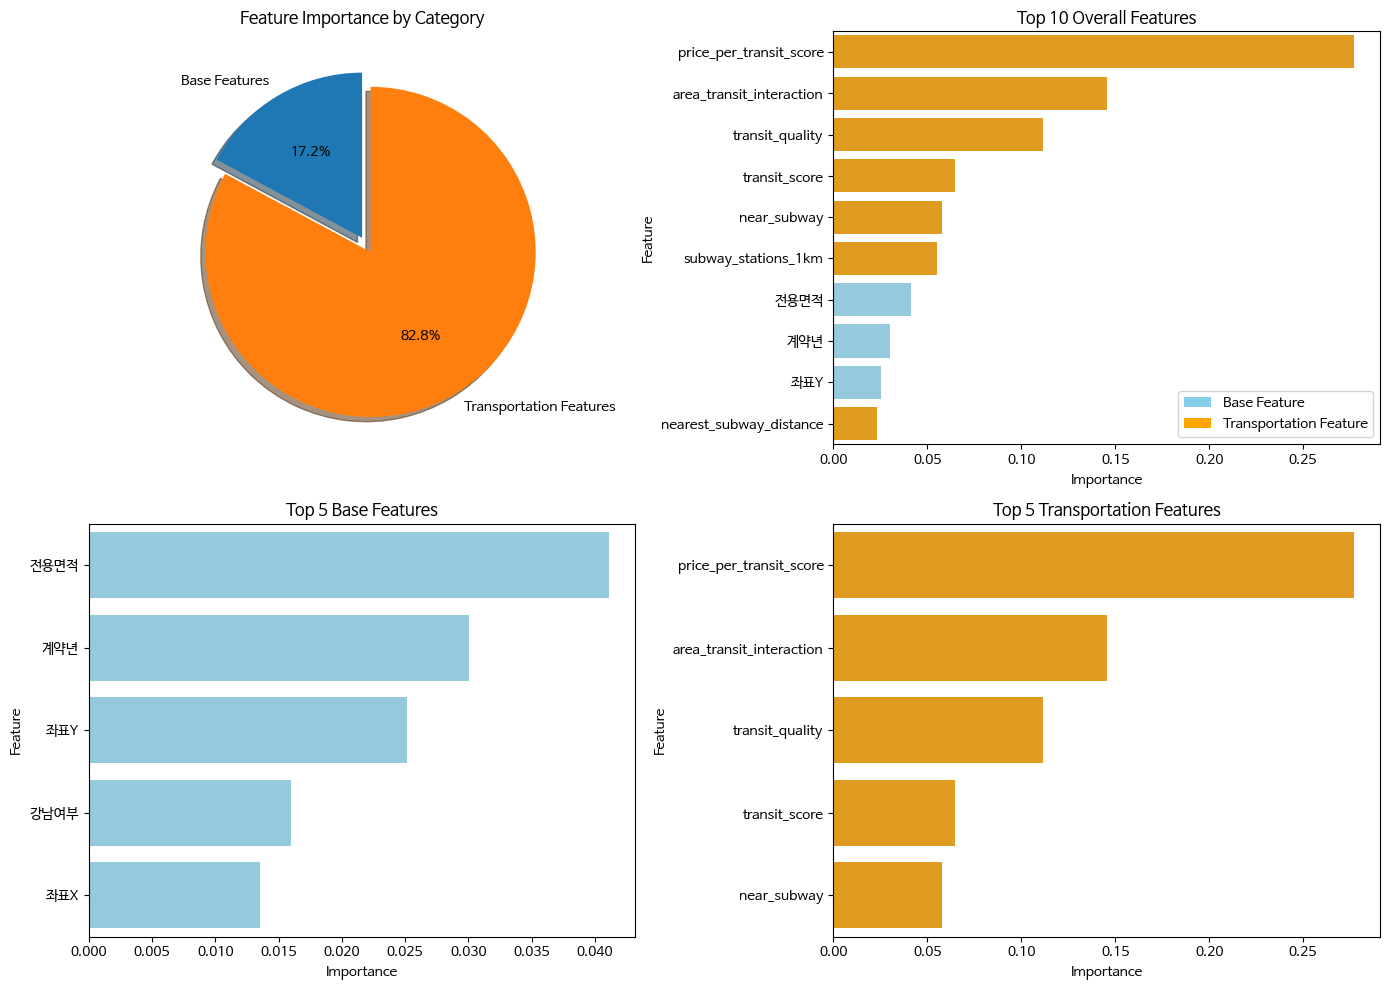

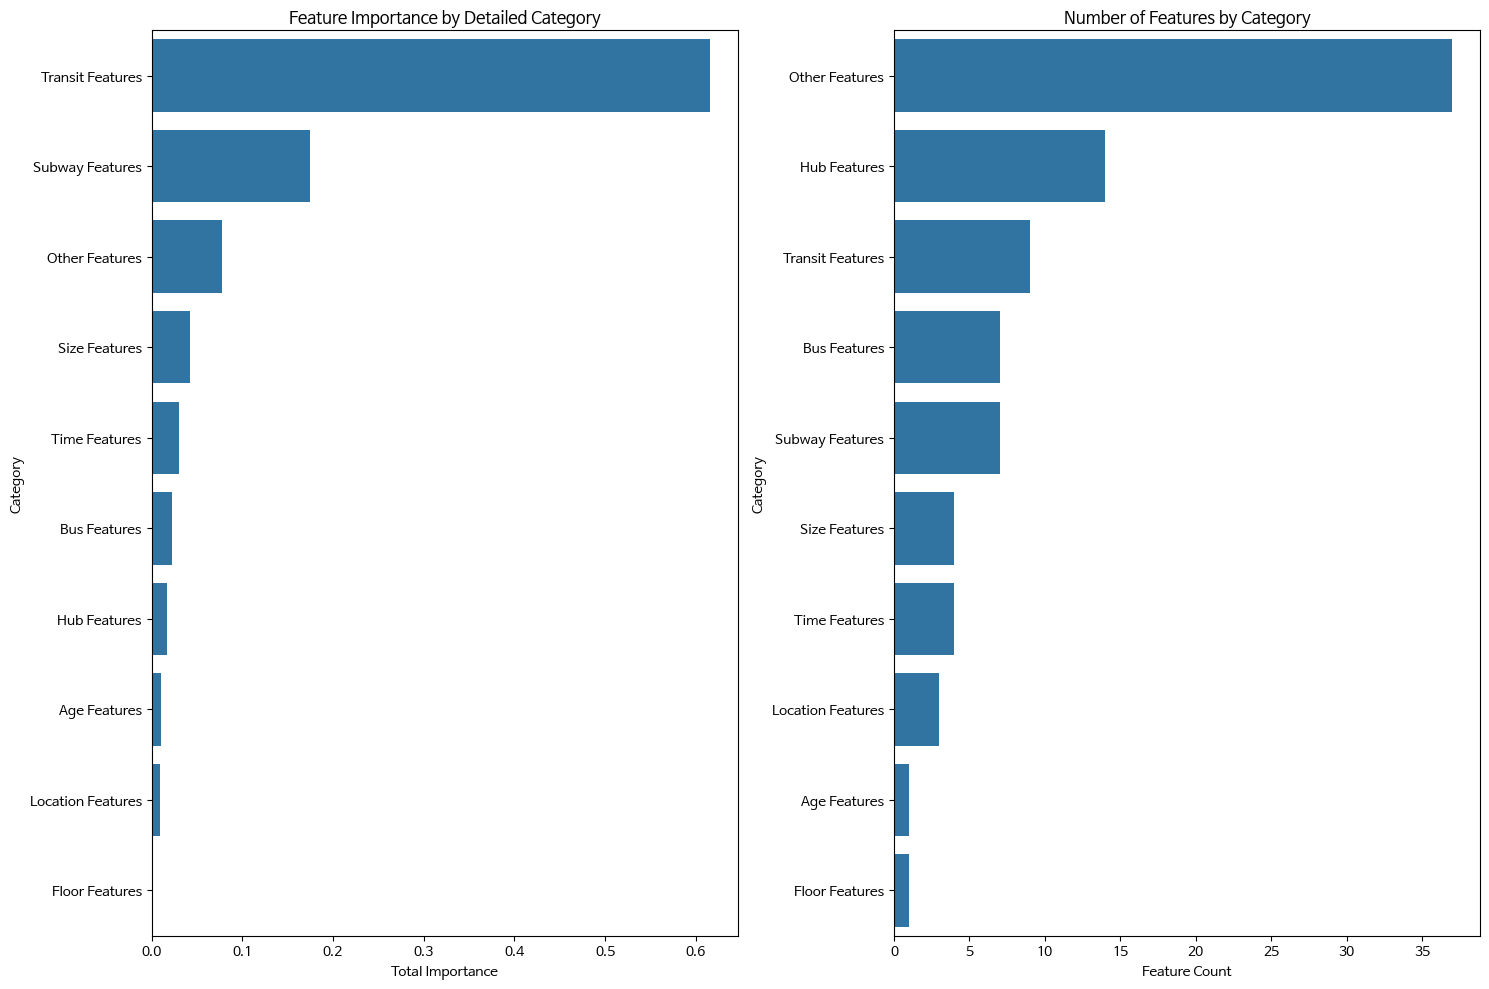


Top Features by Category:

Transit Features:
- price_per_transit_score: 0.2771
- area_transit_interaction: 0.1456
- transit_quality: 0.1114

Subway Features:
- near_subway: 0.0579
- subway_stations_1km: 0.0552
- nearest_subway_distance: 0.0230

Other Features:
- 좌표Y: 0.0252
- 강남여부: 0.0160
- 좌표X: 0.0136

Size Features:
- 전용면적: 0.0411
- k-주거전용면적: 0.0005
- k-전용면적별세대현황(60㎡~85㎡이하): 0.0004

Time Features:
- 계약년: 0.0300
- 계약일: 0.0003
- 세대전기계약방법: 0.0003

Bus Features:
- nearest_bus_distance: 0.0222
- near_bus: 0.0000
- bus_stops_500m: 0.0000

Hub Features:
- nearby_hub_count: 0.0058
- nearest_major_hub_id: 0.0029
- near_major_hub: 0.0024

Age Features:
- 건축년도: 0.0105

Location Features:
- 구: 0.0072
- 동: 0.0021
- k-전체동수: 0.0003

Floor Features:
- 층: 0.0004


In [83]:
#############################################################
# 7.4 COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS
#############################################################
print("\n=== Comprehensive Feature Importance Analysis ===")

# Identify base features vs transportation features
base_features = [col for col in importance_df['Feature'] if not any(term in col for term in 
                                                                 ['subway', 'bus', 'transit', 'hub'])]
transport_features = [col for col in importance_df['Feature'] if any(term in col for term in 
                                                                  ['subway', 'bus', 'transit', 'hub'])]

print(f"Model uses {len(base_features)} base features and {len(transport_features)} transportation features")

# Calculate importance by feature type
base_importance = importance_df[importance_df['Feature'].isin(base_features)]['Importance'].sum()
transport_importance = importance_df[importance_df['Feature'].isin(transport_features)]['Importance'].sum()

# Print relative importance
total_importance = base_importance + transport_importance
print(f"Base features account for {base_importance/total_importance:.1%} of total feature importance")
print(f"Transportation features account for {transport_importance/total_importance:.1%} of total feature importance")

# Create visualization of feature categories
plt.figure(figsize=(14, 10))

# Plot 1: Base vs Transportation Feature Importance
plt.subplot(2, 2, 1)
category_importances = pd.DataFrame({
    'Category': ['Base Features', 'Transportation Features'],
    'Importance': [base_importance, transport_importance]
})
plt.pie(category_importances['Importance'], 
       labels=category_importances['Category'],
       autopct='%1.1f%%',
       startangle=90,
       explode=(0.1, 0) if base_importance > transport_importance else (0, 0.1),
       shadow=True)
plt.title('Feature Importance by Category')

# Plot 2: Top 10 Overall Features (mixed)
plt.subplot(2, 2, 2)
top_features = importance_df.head(10).copy()
# Color bars by feature type
colors = ['skyblue' if feature in base_features else 'orange' for feature in top_features['Feature']]
sns.barplot(x='Importance', y='Feature', data=top_features, palette=colors)
plt.title('Top 10 Overall Features')
plt.xlabel('Importance')
# Add a legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='skyblue', label='Base Feature'),
    Patch(facecolor='orange', label='Transportation Feature')
]
plt.legend(handles=legend_elements)

# Plot 3: Top 5 Base Features
plt.subplot(2, 2, 3)
top_base = importance_df[importance_df['Feature'].isin(base_features)].head(5)
sns.barplot(x='Importance', y='Feature', data=top_base, color='skyblue')
plt.title('Top 5 Base Features')
plt.xlabel('Importance')

# Plot 4: Top 5 Transportation Features
plt.subplot(2, 2, 4)
top_transport = importance_df[importance_df['Feature'].isin(transport_features)].head(5)
sns.barplot(x='Importance', y='Feature', data=top_transport, color='orange')
plt.title('Top 5 Transportation Features')
plt.xlabel('Importance')

plt.tight_layout()
plt.savefig('./outputs/comprehensive_feature_importance.png')
plt.show()

# Create more detailed categorization of features
def categorize_feature(feature):
    """Categorize features into more specific groups"""
    if 'subway' in feature:
        return 'Subway Features'
    elif 'bus' in feature:
        return 'Bus Features'
    elif 'transit' in feature:
        return 'Transit Features'
    elif 'hub' in feature:
        return 'Hub Features'
    elif any(term in feature for term in ['전용면적', 'area']):
        return 'Size Features'
    elif any(term in feature for term in ['층', 'floor']):
        return 'Floor Features'
    elif any(term in feature for term in ['건축년도', 'year']):
        return 'Age Features'
    elif any(term in feature for term in ['구', '동', 'district']):
        return 'Location Features'
    elif any(term in feature for term in ['계약', 'date', 'month', 'year']):
        return 'Time Features'
    else:
        return 'Other Features'

# Apply categorization
importance_df['Category'] = importance_df['Feature'].apply(categorize_feature)

# Plot detailed category breakdown
plt.figure(figsize=(15, 10))

# Calculate importance by detailed category
category_importance = importance_df.groupby('Category')['Importance'].sum().reset_index()
category_importance = category_importance.sort_values('Importance', ascending=False)

# Plot category breakdown
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Category', data=category_importance)
plt.title('Feature Importance by Detailed Category')
plt.xlabel('Total Importance')

# Plot feature count by category
category_counts = importance_df.groupby('Category').size().reset_index(name='Count')
category_counts = category_counts.sort_values('Count', ascending=False)

plt.subplot(1, 2, 2)
sns.barplot(x='Count', y='Category', data=category_counts)
plt.title('Number of Features by Category')
plt.xlabel('Feature Count')

plt.tight_layout()
plt.savefig('./outputs/detailed_category_breakdown.png')
plt.show()

# Print top 3 features by category
print("\nTop Features by Category:")
for category in category_importance['Category']:
    top_in_category = importance_df[importance_df['Category'] == category].head(3)
    print(f"\n{category}:")
    for _, row in top_in_category.iterrows():
        print(f"- {row['Feature']}: {row['Importance']:.4f}")

#### 8. INFERENCE ON TEST DATA

In [84]:

#############################################################
# 8. INFERENCE ON TEST DATA 
#############################################################
print("Applying best model from fold", best_model_idx + 1)

# Get the best model and its parameters
best_model = best_model_info['model']
best_feature_scaler = best_model_info['feature_scaler']
best_label_encoders = best_model_info['label_encoders']
best_offset = best_model_info['offset']

# Override preprocessed test data with best model's transformations
X_test_preprocessed = X_test.copy()

# Apply feature scaling from best model
X_test_preprocessed[continuous_columns] = best_feature_scaler.transform(X_test[continuous_columns])

# Apply label encoding from best model
for col in categorical_columns:
    if col in X_test_preprocessed.columns and col in best_label_encoders:
        # Convert column to string type first to ensure consistency
        X_test_preprocessed[col] = X_test_preprocessed[col].astype(str)
        
        # FIX: Handle unseen categories more safely
        for label in X_test_preprocessed[col].unique():  # Use pandas unique instead of numpy
            if label not in best_label_encoders[col].classes_:
                best_label_encoders[col].classes_ = np.append(best_label_encoders[col].classes_, label)
        
        # Apply the encoding
        X_test_preprocessed[col] = best_label_encoders[col].transform(X_test_preprocessed[col])

# Make predictions on test data (in log space)
test_pred_log = best_model.predict(X_test_preprocessed)

# Transform back to original scale
test_pred_original = np.expm1(test_pred_log) - best_offset

# Convert to integers (if appropriate)
test_pred_final = np.round(test_pred_original).astype(int)

# Create submission file
submission = pd.DataFrame({'target': test_pred_final})
submission.to_csv('xgb_stratified_cv_submission_transportation.csv', index=False)


print("Cross-validated model predictions generated successfully!")

Applying best model from fold 2
Cross-validated model predictions generated successfully!


#### Save Model

In [85]:
# Define the path
path_ = "./models/"

# Create the directory if it doesn't exist
os.makedirs(path_, exist_ok=True)

# Combine path with filename
model_path = os.path.join(path_, 'xgb_transportation_model.pkl')

# Save the model
with open('xgb_transportation_model.pkl', 'wb') as f:
    pickle.dump({
        'model': best_model,
        'feature_scaler': best_feature_scaler,
        'label_encoders': best_label_encoders,
        'offset': best_offset,
        'feature_names': X_train.columns.tolist(),
        'categorical_columns': categorical_columns,
        'continuous_columns': continuous_columns
    }, f)

print(f"Model saved to {model_path}")

Model saved to ./models/xgb_transportation_model.pkl


#### 9: MODEL OPTIMIZATION WITH TRANSPORTATION FEATURES


=== Model Optimization with Transportation Features ===

===== TRANSPORTATION FEATURE IMPORTANCE ANALYSIS =====
Available columns in feature_importances: ['Feature', 'Importance', 'Cumulative_Importance', 'Category']
Found 37 transportation-related features:
nearest_subway_distance, nearest_subway_name, nearest_subway_line, subway_stations_500m, subway_stations_1km, subway_stations_3km, nearest_bus_distance, nearest_bus_name, nearest_bus_type, bus_stops_300m, bus_stops_500m, bus_stops_1km, transit_score, transit_quality, near_subway, near_bus, near_public_transit, nearest_hub_id, nearest_hub_distance, nearest_hub_size, nearest_hub_type, nearest_major_hub_id, nearest_major_hub_distance, nearby_hub_count, hub_proximity_score, hub_quality, near_major_hub, multiple_hubs_nearby, price_per_transit_score, area_transit_interaction, new_building_near_transit, old_building_near_transit, gangnam_good_transit, high_floor_near_transit, area_hub_interaction, new_building_near_hub, gangnam_good_hub


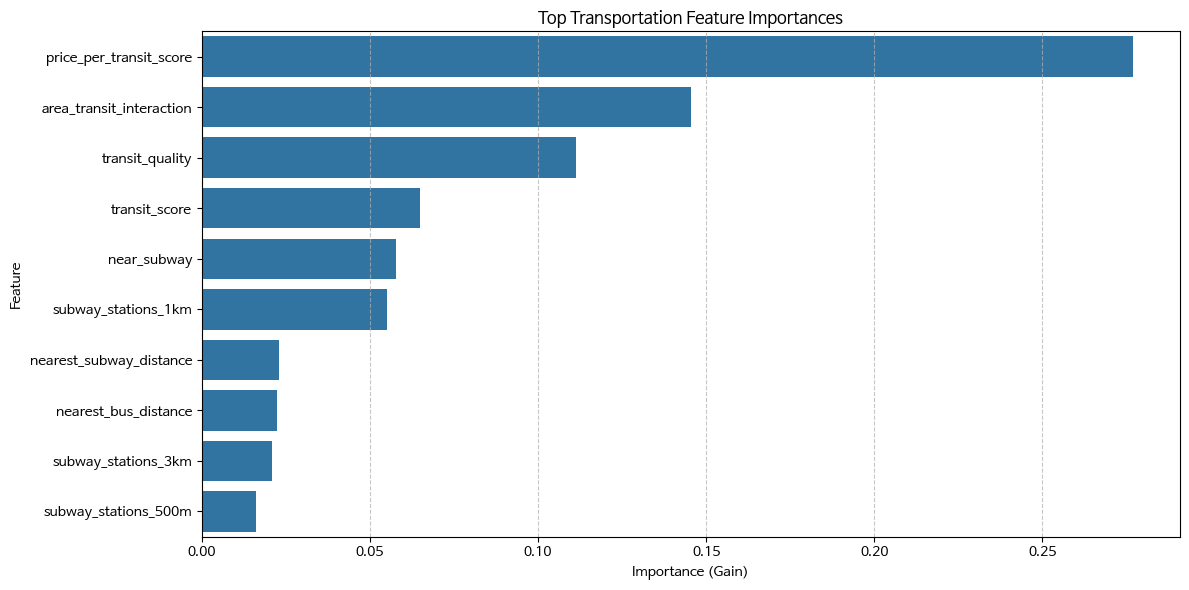


Comparing with other feature categories:


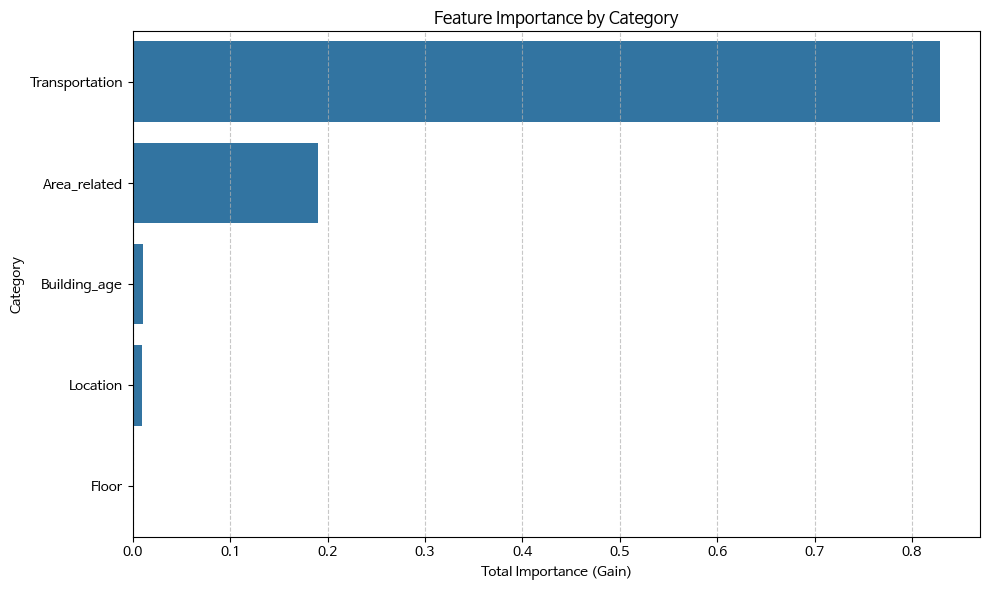


Recommendations for next steps:
1. Consider limiting transportation features to the top 5-7 most important ones
2. Try different cutoff distances for transportation proximity (e.g., 800m vs 1km)
3. Experiment with different hub clustering parameters (eps and min_samples)
4. Create more interaction features between transportation and high-value areas


In [86]:
#############################################################
# 9. MODEL OPTIMIZATION WITH TRANSPORTATION FEATURES
#############################################################
print("\n=== Model Optimization with Transportation Features ===")

# Force reload the module to get the updated version
import importlib
import transport_feature_analysis
importlib.reload(transport_feature_analysis)
from transport_feature_analysis import analyze_transportation_features

# Create metrics dict with feature importances
model_metrics = {
    'feature_importances': importance_df
}

# Run detailed analysis of transportation feature impact
analyze_transportation_features(model_metrics, X_train)

print("\nRecommendations for next steps:")
print("1. Consider limiting transportation features to the top 5-7 most important ones")
print("2. Try different cutoff distances for transportation proximity (e.g., 800m vs 1km)")
print("3. Experiment with different hub clustering parameters (eps and min_samples)")
print("4. Create more interaction features between transportation and high-value areas")

#### Section 10: TRANSPORTATION FEATURE IMPORTANCE VISUALIZATION


=== Transportation Feature Importance Visualization ===


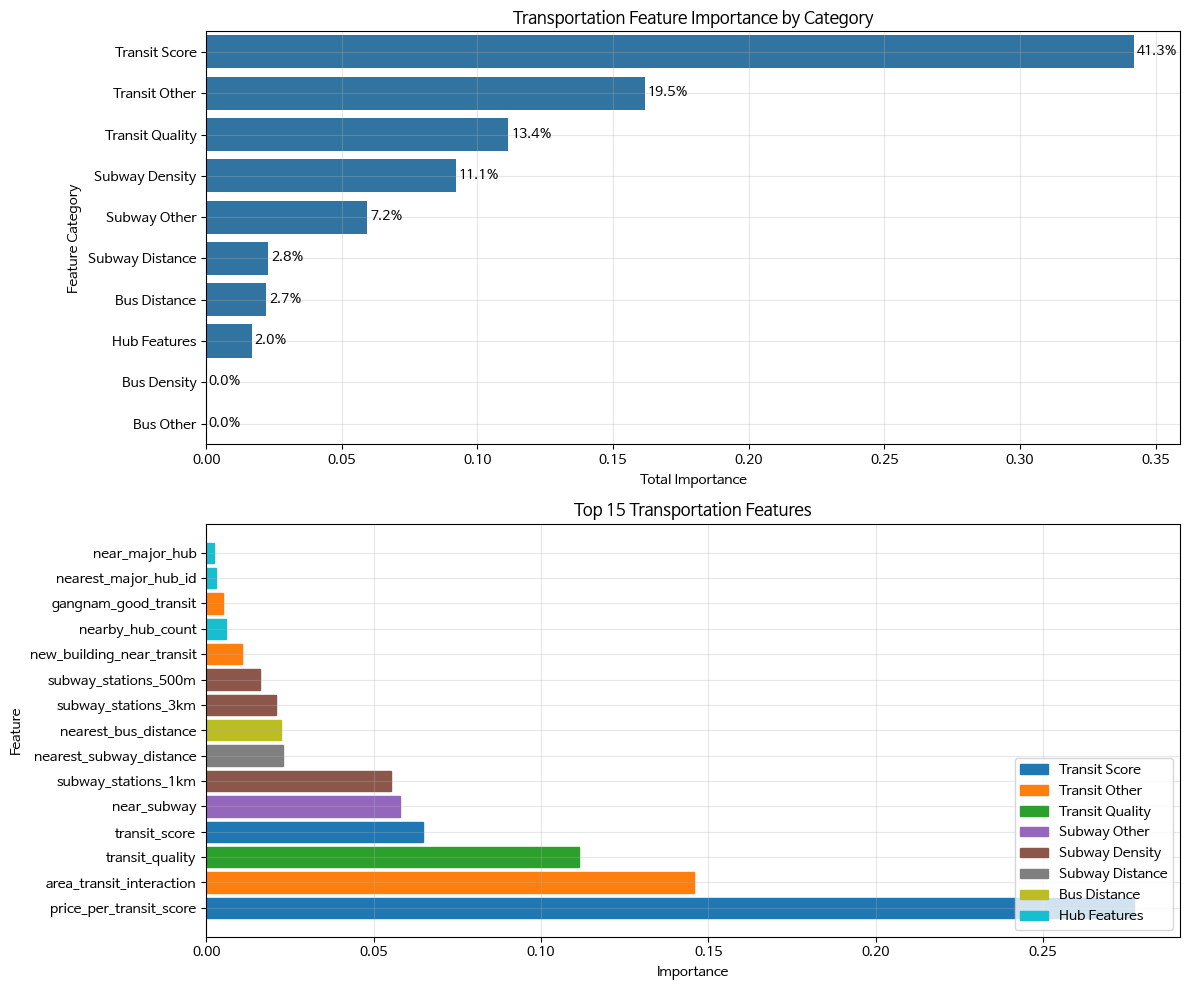

/tmp/ipykernel_124237/3212379423.py:131: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/tmp/ipykernel_124237/3212379423.py:133: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.draw()
/tmp/ipykernel_124237/3212379423.py:143: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.savefig('./outputs/transport_feature_relationships.png')


<Figure size 1400x800 with 0 Axes>

/data/ephemeral/home/miniconda3/envs/py39-rapids-env1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


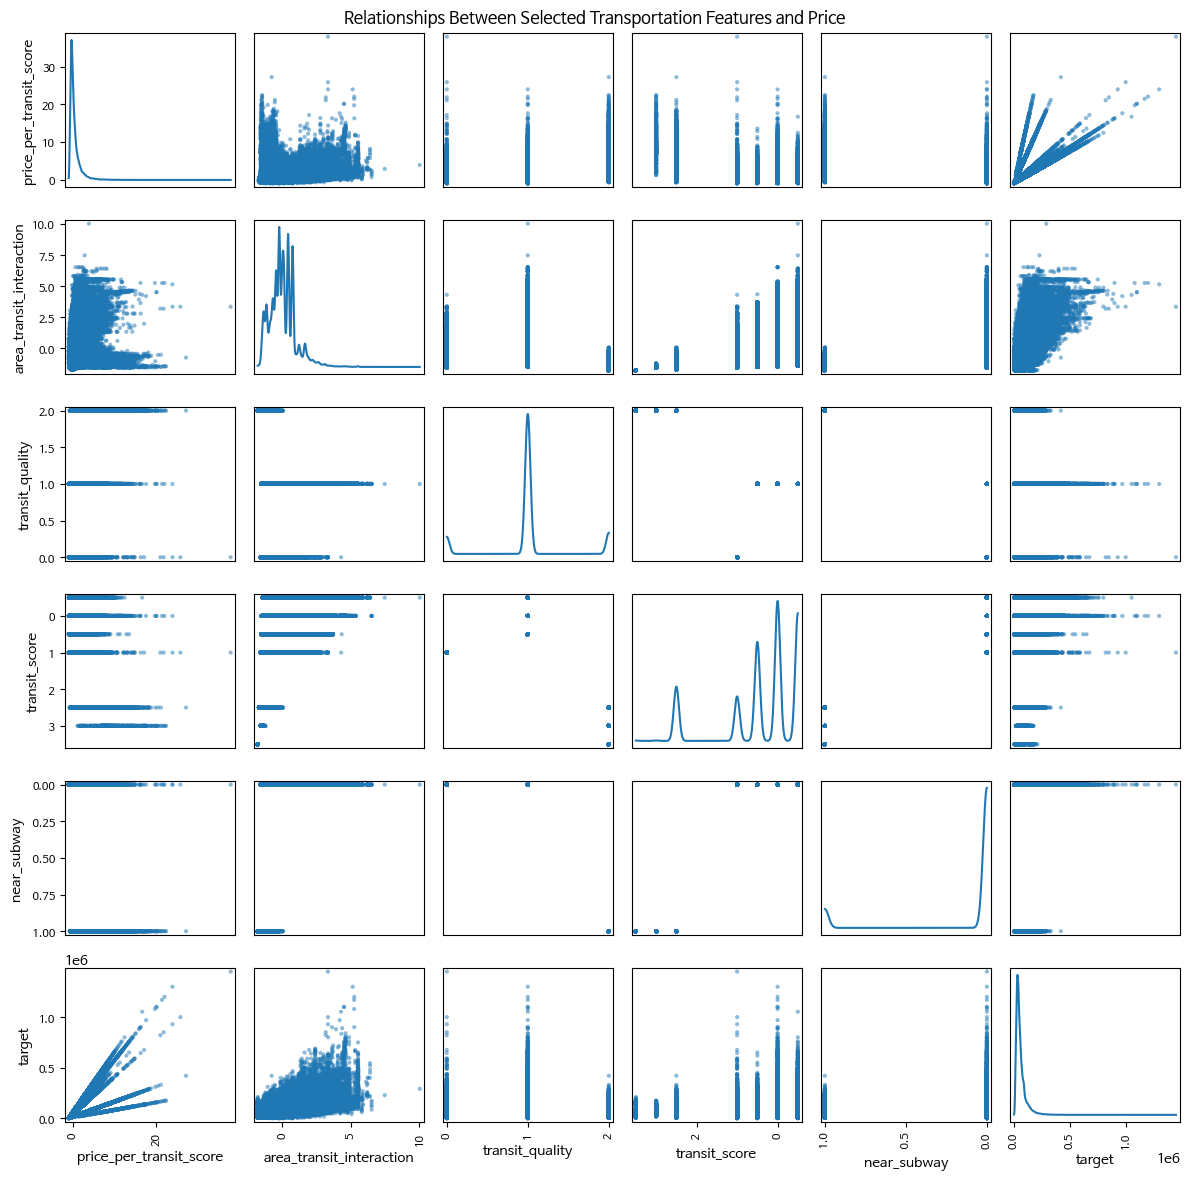


Top Transportation Features Relationship Diagram generated
Features included: ['price_per_transit_score', 'area_transit_interaction', 'transit_quality', 'transit_score', 'near_subway']

Transportation features account for 82.85% of total feature importance
Top 5 most important transportation features:
- price_per_transit_score: 0.2771
- area_transit_interaction: 0.1456
- transit_quality: 0.1114
- transit_score: 0.0648
- near_subway: 0.0579


In [87]:
#############################################################
# 10. TRANSPORTATION FEATURE IMPORTANCE VISUALIZATION
#############################################################
print("\n=== Transportation Feature Importance Visualization ===")

# Identify transportation features and their importances
transport_cols = [col for col in importance_df['Feature'] if any(term in col for term in 
                                                             ['subway', 'bus', 'transit', 'hub'])]

if transport_cols:
    # Filter the importance DataFrame for transportation features
    transport_importances = importance_df[importance_df['Feature'].isin(transport_cols)].copy()
    
    # If we have enough transportation features, categorize them
    if len(transport_importances) >= 5:
        # Add feature categories
        def categorize_transport_feature(feature_name):
            if 'subway' in feature_name:
                if 'distance' in feature_name:
                    return 'Subway Distance'
                elif 'station' in feature_name:
                    return 'Subway Density'
                else:
                    return 'Subway Other'
            elif 'bus' in feature_name:
                if 'distance' in feature_name:
                    return 'Bus Distance'
                elif 'stop' in feature_name:
                    return 'Bus Density'
                else:
                    return 'Bus Other'
            elif 'hub' in feature_name:
                return 'Hub Features'
            elif 'transit' in feature_name:
                if 'score' in feature_name:
                    return 'Transit Score'
                elif 'quality' in feature_name:
                    return 'Transit Quality'
                else:
                    return 'Transit Other'
            else:
                return 'Other Transportation'
        
        # Apply categorization
        transport_importances['Category'] = transport_importances['Feature'].apply(categorize_transport_feature)
        
        # Create stacked visualization of feature importance by category
        category_importance = transport_importances.groupby('Category')['Importance'].sum().reset_index()
        category_importance = category_importance.sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(12, 10))
        
        # Plot 1: Stacked bar showing feature importance by category
        plt.subplot(2, 1, 1)
        ax = sns.barplot(x='Importance', y='Category', data=category_importance)
        
        # Add percentage to the bars
        total_importance = category_importance['Importance'].sum()
        for i, v in enumerate(category_importance['Importance']):
            ax.text(v + 0.001, i, f"{v/total_importance:.1%}", va='center')
        
        plt.title('Transportation Feature Importance by Category')
        plt.xlabel('Total Importance')
        plt.ylabel('Feature Category')
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Top 15 individual transportation features
        plt.subplot(2, 1, 2)
        top_features = transport_importances.sort_values('Importance', ascending=False).head(15)
        
        # Create a colormap based on categories
        unique_categories = top_features['Category'].unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_categories)))
        category_colors = dict(zip(unique_categories, colors))
        
        # Use the colors in the bar plot
        bars = plt.barh(top_features['Feature'], top_features['Importance'])
        
        # Color bars by category
        for i, bar in enumerate(bars):
            bar.set_color(category_colors[top_features.iloc[i]['Category']])
        
        # Add a legend
        legend_patches = [plt.Rectangle((0,0),1,1, color=category_colors[cat]) for cat in unique_categories]
        plt.legend(legend_patches, unique_categories, loc='lower right')
        
        plt.title('Top 15 Transportation Features')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('./outputs/transport_feature_importance_viz.png')
        plt.show()
        
        # Plot 3: Interactive feature importance exploration
        try:
            from matplotlib.widgets import Slider
            
            # Create interactive visualization to explore feature relationships
            plt.figure(figsize=(14, 8))
            
            # Get top correlated features with price
            if 'target' in best_fold_data['y_train_orig'].index.names:
                # Handle MultiIndex if present
                train_data_for_corr = pd.DataFrame(best_fold_data['X_train'])
                train_data_for_corr['target'] = best_fold_data['y_train_orig'].values
            else:
                # Regular index
                train_data_for_corr = pd.DataFrame(best_fold_data['X_train'])
                train_data_for_corr['target'] = best_fold_data['y_train_orig']
            
            # Filter for transportation features
            transport_features_train = [col for col in train_data_for_corr.columns 
                                       if col in transport_cols and col != 'target']
            
            # Function to plot feature relationships
            def plot_feature_relationships(selected_features):
                plt.clf()
                
                if len(selected_features) >= 2:
                    # Create a scatter matrix of selected features
                    pd.plotting.scatter_matrix(
                        train_data_for_corr[selected_features + ['target']], 
                        alpha=0.5, diagonal='kde', figsize=(12, 12))
                    plt.suptitle('Relationships Between Selected Transportation Features and Price')
                else:
                    plt.text(0.5, 0.5, "Select at least 2 features for comparison", 
                            ha='center', va='center', fontsize=14)
                
                plt.tight_layout()
                plt.subplots_adjust(top=0.95)
                plt.draw()
            
            # Select top 5 transportation features by importance
            top_transport = transport_importances.sort_values('Importance', ascending=False).head(5)
            initial_features = top_transport['Feature'].tolist()
            
            # Create initial plot
            plot_feature_relationships(initial_features)
            
            plt.tight_layout()
            plt.savefig('./outputs/transport_feature_relationships.png')
            plt.show()
            
            print("\nTop Transportation Features Relationship Diagram generated")
            print("Features included:", initial_features)
        except Exception as e:
            print(f"Error creating interactive plot: {e}")
            pass
    else:
        # Simple bar chart for fewer features
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Importance', y='Feature', data=transport_importances.sort_values('Importance', ascending=False))
        plt.title('Transportation Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('./outputs/simple_transport_importance.png')
        plt.show()
    
    # Calculate percentage of total importance from transportation features
    transport_importance_sum = transport_importances['Importance'].sum()
    total_importance_sum = importance_df['Importance'].sum()
    transport_percentage = (transport_importance_sum / total_importance_sum) * 100
    
    print(f"\nTransportation features account for {transport_percentage:.2f}% of total feature importance")
    print(f"Top 5 most important transportation features:")
    for _, row in transport_importances.sort_values('Importance', ascending=False).head(5).iterrows():
        print(f"- {row['Feature']}: {row['Importance']:.4f}")
else:
    print("No transportation features found in the importance DataFrame.")

#### Section 11: GEOGRAPHIC PRICE PREDICTION VISUALIZATION


=== Geographic Price Prediction Visualization ===


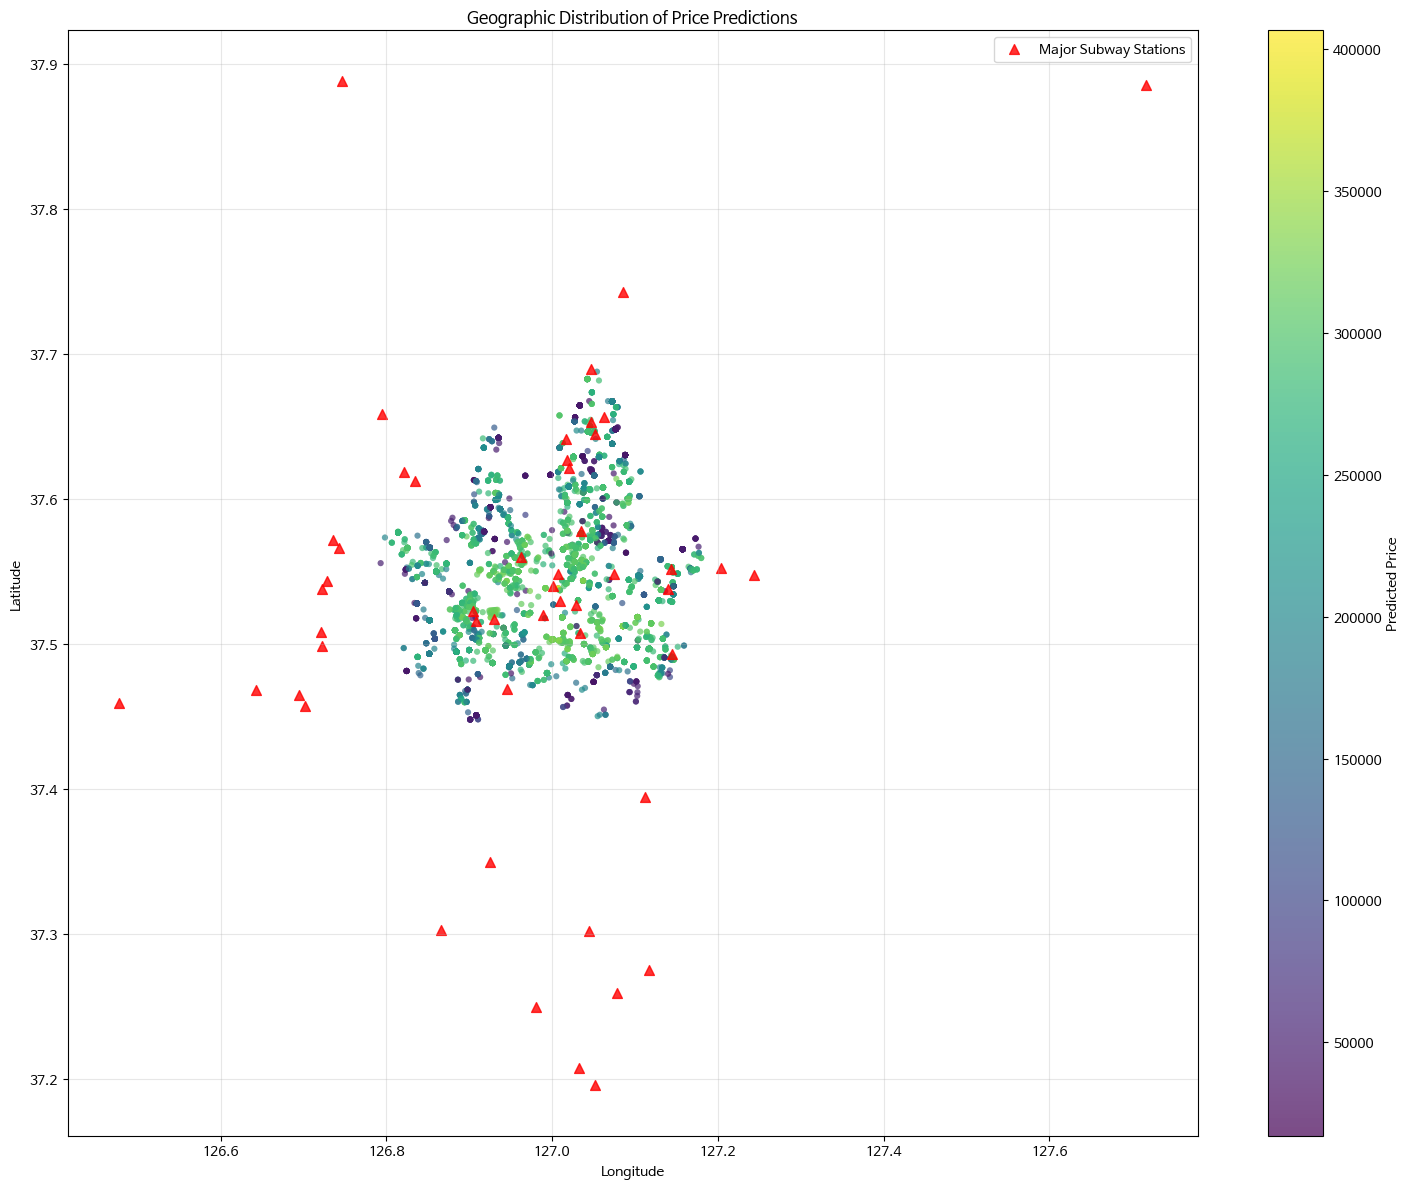

Creating price density heatmap...


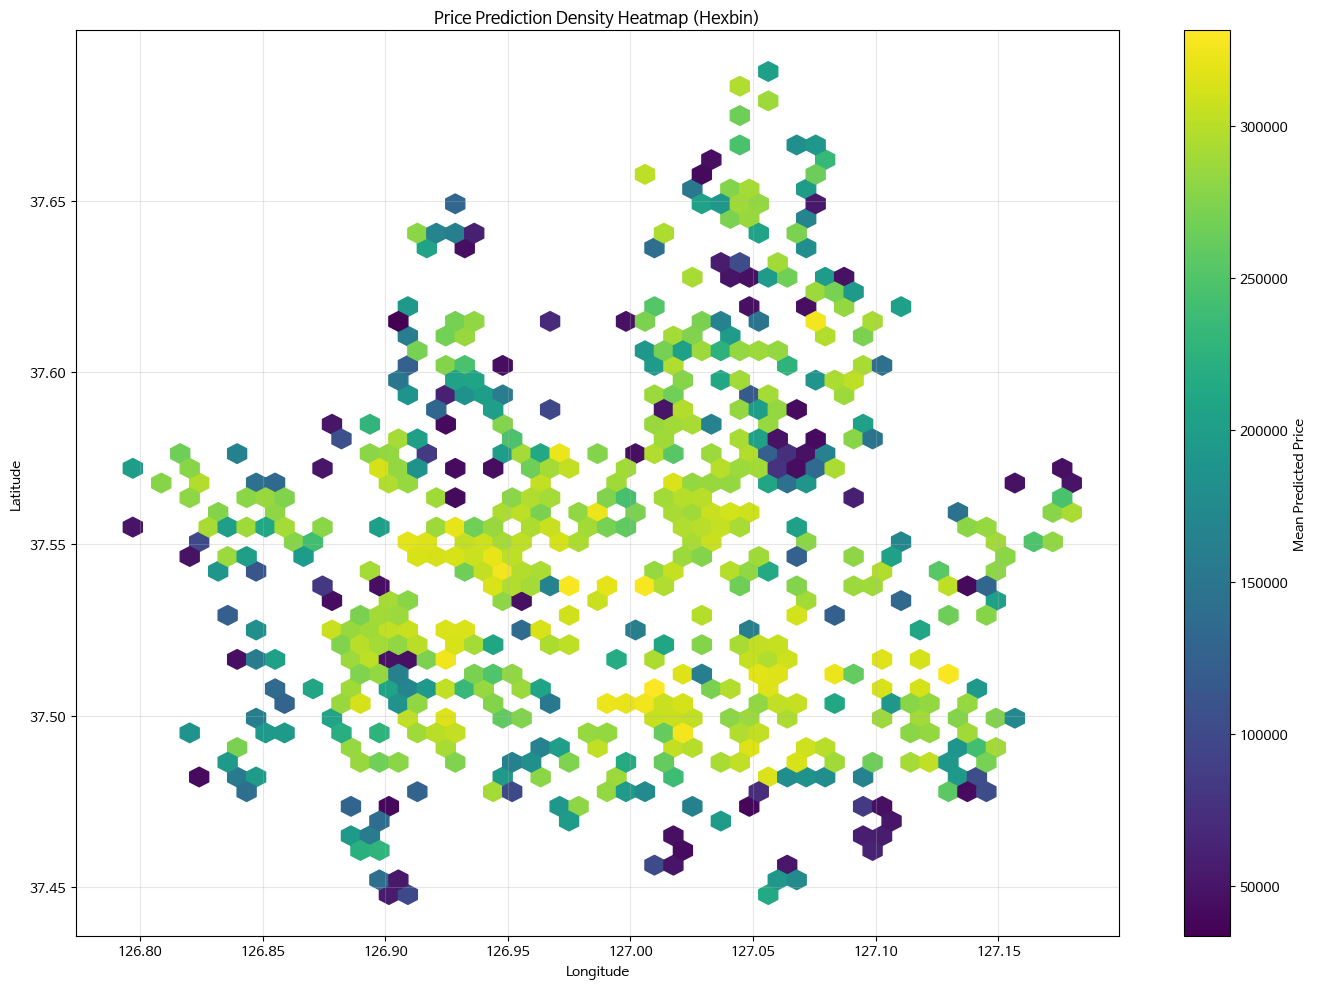

Creating price by region visualization...


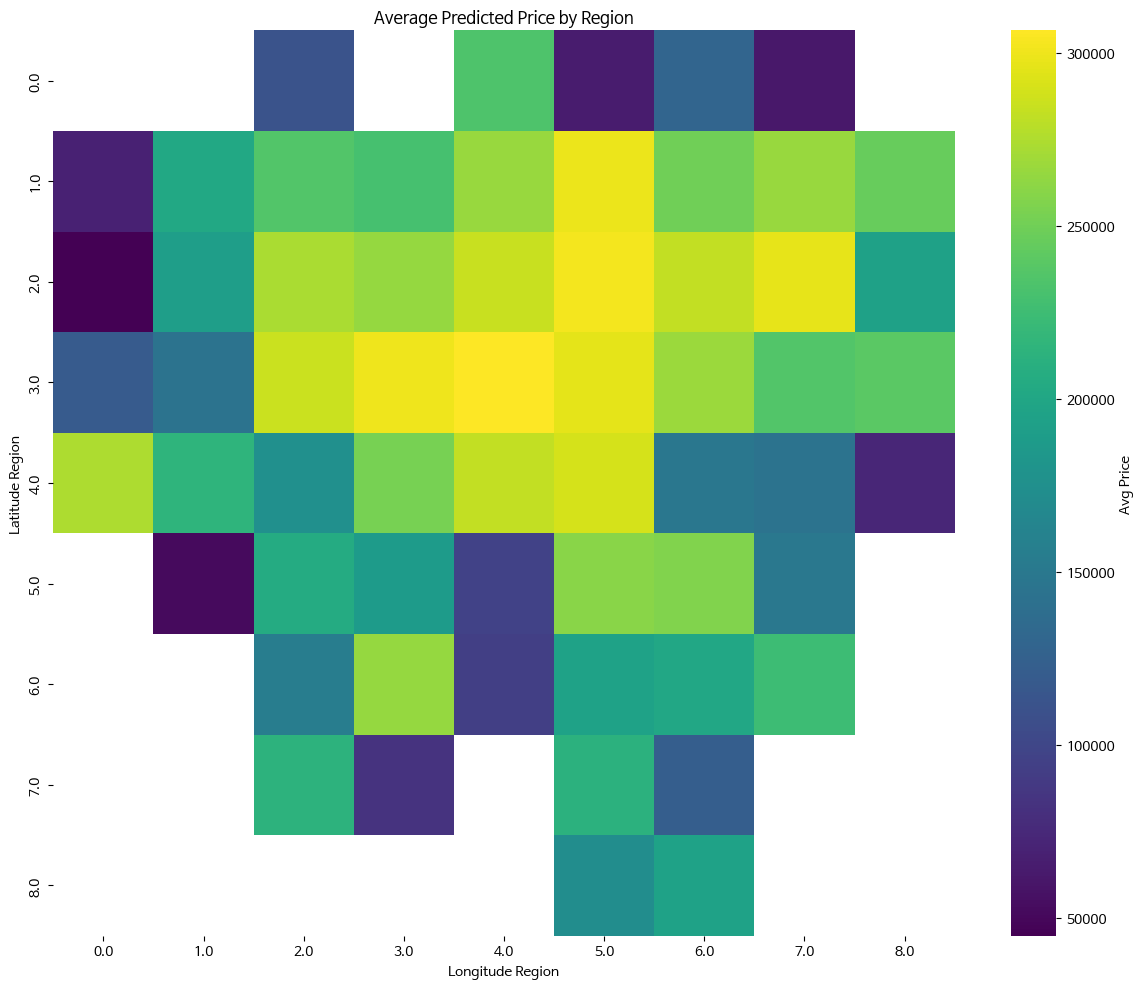

In [ ]:
#############################################################
# 11. GEOGRAPHIC PRICE PREDICTION VISUALIZATION
#############################################################
print("\n=== Geographic Price Prediction Visualization ===")

# Check if we have the necessary data for this visualization
if ('좌표X' in X_test.columns and '좌표Y' in X_test.columns and 
    len(test_pred_final) == len(X_test)):
    
    # Sample for visualization (to avoid overplotting)
    sample_size = min(5000, len(X_test))
    vis_indices = np.random.choice(len(X_test), sample_size, replace=False)
    
    # Create a DataFrame with coordinates and predictions
    geo_viz_data = pd.DataFrame({
        'longitude': X_test.iloc[vis_indices]['좌표X'],
        'latitude': X_test.iloc[vis_indices]['좌표Y'],
        'predicted_price': test_pred_final[vis_indices]
    })
    
    # Remove any NaN or infinite values
    geo_viz_data = geo_viz_data.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Only proceed if we have enough data points
    if len(geo_viz_data) > 10:
        # Create a geographic visualization
        plt.figure(figsize=(15, 12))
        
        # Plot 1: Geographic distribution of predictions
        scatter = plt.scatter(
            geo_viz_data['longitude'], 
            geo_viz_data['latitude'], 
            c=geo_viz_data['predicted_price'],
            cmap='viridis',
            alpha=0.7,
            s=20,
            edgecolors='none'
        )
        
        # Add a colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Predicted Price')
        
        # Add a title and labels
        plt.title('Geographic Distribution of Price Predictions')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid(True, alpha=0.3)
        
        # Try to add a basemap or reference points if available
        try:
            # Add major subway stations if available
            if 'subway_data' in globals() and len(subway_data) > 0:
                # Get major subway stations (limit to avoid clutter)
                major_stations = subway_data.sample(min(50, len(subway_data)), random_state=42)
                
                # Plot these as reference points
                if '위도' in major_stations.columns and '경도' in major_stations.columns:
                    plt.scatter(
                        major_stations['경도'], 
                        major_stations['위도'],
                        c='red',
                        marker='^',
                        s=50,
                        alpha=0.8,
                        label='Major Subway Stations'
                    )
                    plt.legend()
        except Exception as e:
            print(f"Error adding reference points: {e}")
        
        # Save and show the plot
        plt.tight_layout()
        plt.savefig('./outputs/geographic_predictions.png')
        plt.show()
        
        # Create a simple binned heatmap instead of using gaussian_kde
        try:
            print("Creating price density heatmap...")
            plt.figure(figsize=(14, 10))
            
            # Use hexbin which is more robust than gaussian_kde
            hb = plt.hexbin(
                geo_viz_data['longitude'], 
                geo_viz_data['latitude'], 
                C=geo_viz_data['predicted_price'], 
                gridsize=50,  # Adjust this value to control the resolution
                cmap='viridis',
                reduce_C_function=np.mean  # Use mean price in each hexbin
            )
            
            # Add a colorbar
            cb = plt.colorbar(hb, label='Mean Predicted Price')
            
            # Add a title and labels
            plt.title('Price Prediction Density Heatmap (Hexbin)')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.grid(True, alpha=0.3)
            
            # Save and show the plot
            plt.tight_layout()
            plt.savefig('./outputs/price_hexbin_map.png')
            plt.show()
            
        except Exception as e:
            print(f"Error creating hexbin map: {e}")
            
            # Try an even simpler alternative - 2D histogram
            try:
                print("Trying alternative visualization method...")
                plt.figure(figsize=(14, 10))
                
                # Create 2D histogram
                plt.hist2d(
                    geo_viz_data['longitude'], 
                    geo_viz_data['latitude'], 
                    bins=(30, 30),
                    cmap='viridis'
                )
                
                plt.colorbar(label='Count')
                plt.title('Property Density Heatmap')
                plt.xlabel('Longitude')
                plt.ylabel('Latitude')
                plt.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.savefig('./outputs/property_density_heatmap.png')
                plt.show()
            except Exception as e:
                print(f"Error creating alternative visualization: {e}")
                
        # Create a simple price by region visualization
        try:
            print("Creating price by region visualization...")
            
            # Define a grid for regional averaging
            lon_min, lon_max = geo_viz_data['longitude'].min(), geo_viz_data['longitude'].max()
            lat_min, lat_max = geo_viz_data['latitude'].min(), geo_viz_data['latitude'].max()
            
            # Create region boundaries (10x10 grid)
            lon_bins = np.linspace(lon_min, lon_max, 10)
            lat_bins = np.linspace(lat_min, lat_max, 10)
            
            # Assign each point to a region
            geo_viz_data['lon_bin'] = pd.cut(geo_viz_data['longitude'], lon_bins, labels=False)
            geo_viz_data['lat_bin'] = pd.cut(geo_viz_data['latitude'], lat_bins, labels=False)
            
            # Calculate average price by region
            region_prices = geo_viz_data.groupby(['lon_bin', 'lat_bin'])['predicted_price'].mean().reset_index()
            
            # Create a visualization
            plt.figure(figsize=(12, 10))
            
            # Create a pivot table for the heatmap
            pivot_data = region_prices.pivot(index='lat_bin', columns='lon_bin', values='predicted_price')
            
            # Plot heatmap
            sns.heatmap(pivot_data, cmap='viridis', annot=False, fmt=".0f", cbar_kws={'label': 'Avg Price'})
            
            plt.title('Average Predicted Price by Region')
            plt.xlabel('Longitude Region')
            plt.ylabel('Latitude Region')
            
            plt.tight_layout()
            plt.savefig('./outputs/region_price_heatmap.png')
            plt.show()
            
        except Exception as e:
            print(f"Error creating regional price map: {e}")
    else:
        print("Not enough valid data points for geographic visualization")
else:
    print("Required columns for geographic visualization not available.")